## Cooling Tank Model

This notebook describes the optimization of the tank model described in `tank_model.py`. This model was developed in the fmdtools package, and requires its installation to simulate.

In [3]:
import sys
sys.path.append('../')
import numpy as np
import scipy as sp
import time
import itertools
import random
from scipy.optimize import minimize
import pandas as pd
import pickle

import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd
from tank_model import Tank
from fmdtools.modeldef import SampleApproach

import matplotlib.pyplot as plt

# Simulation

### Verifying the nominal state:

In the nominal state, no change in system state should occurs.

In [4]:
mdl = Tank()
endresults, resgraph, mdlhist = propagate.nominal(mdl)

In [5]:
mdlhist.keys()

dict_keys(['flows', 'functions', 'time'])

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

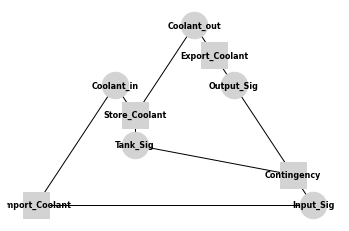

In [4]:
rd.graph.show(resgraph)

C:\Users\dhulse\Anaconda3\lib\site-packages\fmdtools\resultdisp\plot.py:254: UserWarning: Deprecated function. Use resultdisp.plot.mdlhists instead.
  warnings.warn("Deprecated function. Use resultdisp.plot.mdlhists instead.")


(<Figure size 432x1728 with 24 Axes>,
 array([<AxesSubplot:title={'center':'flows Coolant_in effort'}>,
        <AxesSubplot:title={'center':'flows Coolant_in rate'}>,
        <AxesSubplot:title={'center':'flows Coolant_out effort'}>,
        <AxesSubplot:title={'center':'flows Coolant_out rate'}>,
        <AxesSubplot:title={'center':'flows Input_Sig indicator'}>,
        <AxesSubplot:title={'center':'flows Input_Sig action'}>,
        <AxesSubplot:title={'center':'flows Tank_Sig indicator'}>,
        <AxesSubplot:title={'center':'flows Tank_Sig action'}>,
        <AxesSubplot:title={'center':'flows Output_Sig indicator'}>,
        <AxesSubplot:title={'center':'flows Output_Sig action'}>,
        <AxesSubplot:title={'center':'functions Import_Coolant faults Leak'}>,
        <AxesSubplot:title={'center':'functions Import_Coolant faults Blockage'}>,
        <AxesSubplot:title={'center':'functions Import_Coolant open'}>,
        <AxesSubplot:title={'center':'functions Import_Coolant mode

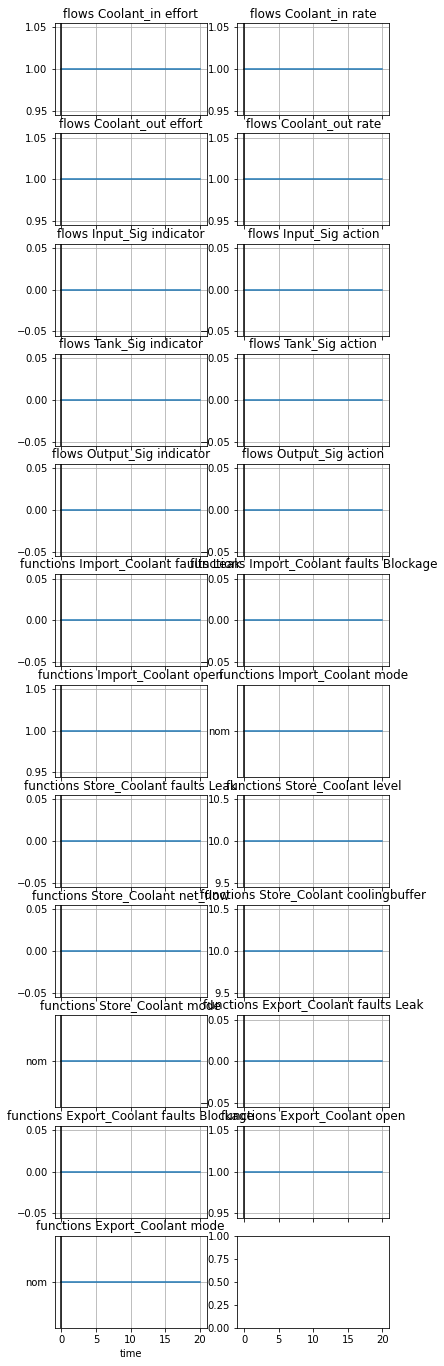

In [5]:
rd.plot.mdlhistvals(mdlhist)

### What happens under component faults?


Here we model a leak of the tank. As shown, the coolant leaks until there is no more coolant left in the tank. While this results in a warning signal, the default contingency management policy is to take no actions to alleviate the condition.

C:\Users\dhulse\Anaconda3\lib\site-packages\fmdtools\resultdisp\plot.py:254: UserWarning: Deprecated function. Use resultdisp.plot.mdlhists instead.
  warnings.warn("Deprecated function. Use resultdisp.plot.mdlhists instead.")


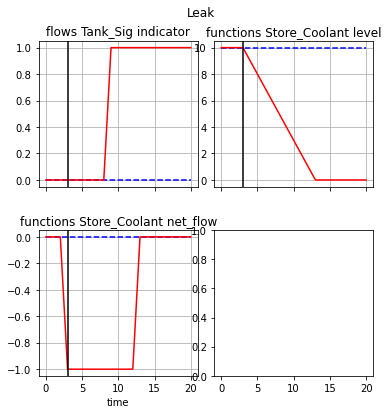

In [7]:
endresults, resgraph, mdlhist = propagate.one_fault(mdl,'Store_Coolant','Leak', time=3, gtype='normal')

fig, ax = rd.plot.mdlhistvals(mdlhist, fault='Leak', time=3, fxnflowvals={'Store_Coolant':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, legend=False) #,
#fig.axes[3].remove()
fig.set_figheight(6)
fig.set_figwidth(6)
fig.subplots_adjust(top = 0.9, wspace=0.1, hspace=0.3)

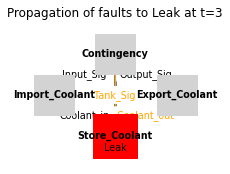

In [8]:
#add graph view to figure
import networkx as nx
graph_fig, graph_ax = rd.graph.show(resgraph,faultscen='Leak', time=3, scale=0.8, gtype='normal', pos=nx.shell_layout(resgraph))
graph_ax.figure = fig
fig.axes.append(graph_ax)
fig.add_axes(graph_ax)
graph_ax.set_position([0.6,0.10,0.5,0.5])
graph_ax.margins(0.3)

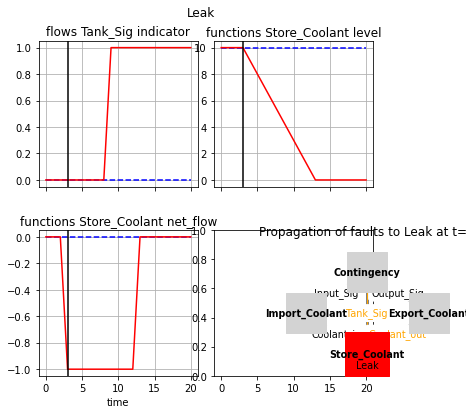

In [9]:
fig

In [10]:
fig.savefig('tank_behavior.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

### Full set of modes

The tank leak mode will not be the only mode considered, but also leak and blockage faults in the Imput/Output blocks.

In [11]:
app_joint_faults = SampleApproach(mdl)
endclasses, mdlhists = propagate.approach(mdl, app_joint_faults)
fmea_tab = rd.tabulate.simplefmea(endclasses)
fmea_tab

SCENARIOS COMPLETE: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 278.51it/s]


,rate,cost,expected cost
"Import_Coolant Leak, t=0",0.000002,2100000.0,350000.000000
"Import_Coolant Blockage, t=0",0.000002,2100000.0,350000.000000
"Store_Coolant Leak, t=0",0.000002,1000000.0,166666.666667
"Export_Coolant Leak, t=0",0.000002,1000000.0,166666.666667
"Export_Coolant Blockage, t=0",0.000002,100000.0,16666.666667
nominal,1.000000,0.0,0.000000


In [12]:
print(fmea_tab.to_latex(float_format="%.2g"))

\begin{tabular}{lrrr}
\toprule
{} &    rate &    cost &  expected cost \\
\midrule
Import\_Coolant Leak, t=0     & 1.7e-06 & 2.1e+06 &        3.5e+05 \\
Import\_Coolant Blockage, t=0 & 1.7e-06 & 2.1e+06 &        3.5e+05 \\
Store\_Coolant Leak, t=0      & 1.7e-06 &   1e+06 &        1.7e+05 \\
Export\_Coolant Leak, t=0     & 1.7e-06 &   1e+06 &        1.7e+05 \\
Export\_Coolant Blockage, t=0 & 1.7e-06 &   1e+05 &        1.7e+04 \\
nominal                      &       1 &       0 &              0 \\
\bottomrule
\end{tabular}



### Optimization

Here we compare the optimization of the response of this system using bilevel and alternating architectures

In [13]:
import importlib
import tank_opt
import multiprocessing as mp
importlib.reload(tank_opt)
pool = mp.Pool(5)

alternating optimization structure

In [14]:
result_alt, llargs_alt, fhist_alt, thist_alt, xdhist_alt = tank_opt.alternating_opt(pool=pool)

[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.0171875   0.48164062]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00071716  0.45401688]
[22.00376129  0.43635979]
[22.00105362  0.4352232 ]
[22.00578804  0.39934072]
[22.00273991  0.37912631]
[22.01068468  0.29725416]
[22.0085608   0.21588925]
[2.20233884e+01 1.14624918e-02]
[22.02126453  0.        ]
[22.01544363  0.11081025]
[22.00828543  0.14329039]
[22.00828543  0.14329039]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[22.00024225  0.        ]
[22.00024225  0.        ]
[2.20001588e+01 4.50371437e-03

['iter 28: ', 277999.99999999994]
['iter 29: ', 277999.99999999994]
['iter 30: ', 277999.99999999994]
['iter 31: ', 277999.99999999994]
['iter 32: ', 277999.99999999994]
['iter 33: ', 277999.99999999994]
['iter 34: ', 277999.99999999994]
['iter 35: ', 277999.99999999994]
['iter 36: ', 277999.99999999994]
['iter 37: ', 277999.99999999994]
['iter 38: ', 277999.99999999994]
['iter 39: ', 277999.99999999994]
['iter 40: ', 277999.99999999994]
['iter 41: ', 277999.99999999994]
['iter 42: ', 277999.99999999994]
['iter 43: ', 277999.99999999994]
['iter 44: ', 277999.99999999994]
['iter 45: ', 277999.99999999994]
['iter 46: ', 277999.99999999994]
['iter 47: ', 277999.99999999994]
['iter 48: ', 277999.99999999994]
['iter 49: ', 277999.99999999994]
['iter 50: ', 277999.99999999994]
['iter 51: ', 277999.99999999994]
['iter 52: ', 277999.99999999994]
['iter 53: ', 277999.99999999994]
['iter 54: ', 277999.99999999994]
['iter 55: ', 277999.99999999994]
['iter 56: ', 277999.99999999994]
['iter 57: ', 

[20.03125  0.     ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.000003

['iter 28: ', 343666.6666666666]
['iter 29: ', 343666.6666666666]
['iter 30: ', 343666.6666666666]
['iter 31: ', 343666.6666666666]
['iter 32: ', 343666.6666666666]
['iter 33: ', 343666.6666666666]
['iter 34: ', 343666.6666666666]
['iter 35: ', 343666.6666666666]
['iter 36: ', 343666.6666666666]
['iter 37: ', 343666.6666666666]
['iter 38: ', 343666.6666666666]
['iter 39: ', 343666.6666666666]
['iter 40: ', 343666.6666666666]
['iter 41: ', 343666.6666666666]
['iter 42: ', 343666.6666666666]
['iter 43: ', 343666.6666666666]
['iter 44: ', 343666.6666666666]
['iter 45: ', 343666.6666666666]
['iter 46: ', 343666.6666666666]
['iter 47: ', 343666.6666666666]
['iter 48: ', 343666.6666666666]
['iter 49: ', 343666.6666666666]
['iter 50: ', 343666.6666666666]
['iter 51: ', 343666.6666666666]
['iter 52: ', 343666.6666666666]
['iter 53: ', 343666.6666666666]
['iter 54: ', 343666.6666666666]
['iter 55: ', 343666.6666666666]
['iter 56: ', 343666.6666666666]
['iter 57: ', 343666.6666666666]
['iter 58:

In [16]:
result_alt.fun

453666.6668231288

In [31]:
result_alt_nocr, llargs_alt_nocr, fhist_alt_nocr, thist_alt_nocr, xdhist_alt_nocr = tank_opt.alternating_opt(option="without_cr",pool=pool)

[18.9     0.5375]
[17.85     0.50625]
[13.125     0.565625]
[10.         0.5328125]
[10.         0.5328125]
[10.         0.5328125]
[10.          0.45390625]
[10.          0.36132812]
[10.          0.15722656]
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 24
['iter 0: ', 906666.6666666666]
['iter 1: ', 899999.9999999999]
['iter 2: ', 899999.9999999999]
['iter 3: ', 899999.9999999999]
['iter 4: ', 899999.9999999999]
['iter 5: ', 899999.9999999999]
['iter 6: ', 899999.9999999999]
['iter 7: ', 896666.6666666666]
['iter 8: ', 896666.6666666666]
['iter 9: ', 896666.6666666666]
['iter 10: ', 896666.6666666666]
['iter 11: ', 896666.6666666666]
['iter 12: ', 896666.6666666666]
['iter 13: ', 896666.6666666666]
['iter 14: ', 896666.6666666665]
['iter 15: ', 896666.6666666665]
['iter 16: ', 896666.6666666665]
['iter 17: ', 893333.3333333333]
['iter 18: ', 893333.3333333333]
['ite

['iter 26: ', 893333.3333333333]
['iter 27: ', 893333.3333333333]
['iter 28: ', 893333.3333333333]
['iter 29: ', 893333.3333333333]
['iter 30: ', 893333.3333333333]
['iter 31: ', 893333.3333333333]
['iter 32: ', 893333.3333333333]
['iter 33: ', 893333.3333333333]
['iter 34: ', 893333.3333333333]
['iter 35: ', 893333.3333333333]
['iter 36: ', 893333.3333333333]
['iter 37: ', 893333.3333333333]
['iter 38: ', 893333.3333333333]
['iter 39: ', 893333.3333333333]
['iter 40: ', 893333.3333333333]
['iter 41: ', 893333.3333333333]
['iter 42: ', 893333.3333333333]
['iter 43: ', 893333.3333333333]
['iter 44: ', 893333.3333333333]
['iter 45: ', 893333.3333333333]
['iter 46: ', 893333.3333333333]
['iter 47: ', 893333.3333333333]
['iter 48: ', 893333.3333333333]
['iter 49: ', 893333.3333333333]
['iter 50: ', 893333.3333333333]
['iter 51: ', 893333.3333333333]
['iter 52: ', 893333.3333333333]
['iter 53: ', 893333.3333333333]
['iter 54: ', 893333.3333333333]
['iter 55: ', 893333.3333333333]
['iter 56:

In [35]:
result_bi, llargs_bi, bestf_bi, bestxdes_bi = tank_opt.bilevel_opt(pool=pool)

time: 5.78708553314209 fval: 336333.3333333334 xdes: [21.   0.5]
time: 11.541545391082764 fval: 327919.1666666666 xdes: [22.05  0.5 ]
time: 17.549811840057373 fval: 317089.5833333334 xdes: [21.     0.525]
time: 23.64339828491211 fval: 325675.4166666666 xdes: [22.05   0.525]
[21.     0.525]
time: 29.43894338607788 fval: 317191.6666666666 xdes: [21.    0.55]
[21.     0.525]
time: 35.323543548583984 fval: 310810.8333333334 xdes: [19.95  0.55]
time: 41.21765923500061 fval: 306774.0625000001 xdes: [18.9     0.5625]
[18.9     0.5625]
time: 46.798969745635986 fval: 323332.3958333335 xdes: [18.9     0.5375]
time: 52.59801411628723 fval: 304691.34765625006 xdes: [20.475     0.546875]
[20.475     0.546875]
time: 58.59948801994324 fval: 296763.8997395835 xdes: [18.375     0.584375]
time: 65.14953708648682 fval: 325212.13378906273 xdes: [17.0625     0.6140625]
[18.375     0.584375]
time: 70.97677087783813 fval: 326853.93229166674 xdes: [19.95     0.56875]
time: 76.93263721466064 fval: 310962.23795

time: 560.0846359729767 fval: 286709.4112648579 xdes: [18.00003773  0.58098507]
time: 566.0781786441803 fval: 286709.7582671623 xdes: [18.00005887  0.58098401]
[18.00001545  0.58098156]
time: 571.8756184577942 fval: 305708.6447581001 xdes: [17.99999431  0.58098263]
time: 577.687680721283 fval: 289042.8132224451 xdes: [18.00004273  0.58098366]
time: 583.4466271400452 fval: 286709.2015115846 xdes: [18.00002659  0.58098332]
time: 589.1806263923645 fval: 286709.3750124054 xdes: [18.00003716  0.58098279]
[18.00001545  0.58098156]
time: 595.5286526679993 fval: 286708.81825824594 xdes: [18.00000488  0.5809821 ]
[18.00001545  0.58098156]
time: 601.2216658592224 fval: 307041.9418391422 xdes: [17.99999374  0.58098034]
time: 607.6096754074097 fval: 285709.05325992167 xdes: [18.00001838  0.58098257]
[18.00001545  0.58098156]
time: 613.448739528656 fval: 285709.2267605768 xdes: [18.00002895  0.58098204]
time: 619.3696990013123 fval: 285709.1246348855 xdes: [18.00002293  0.58098206]
[18.00001545  0.

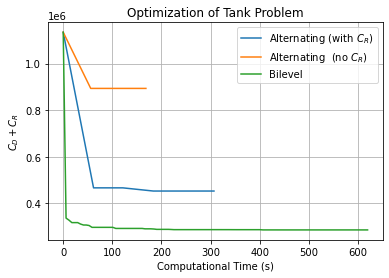

In [58]:
fig = plt.figure()
fhist_alt_plot = [min(fhist_alt[:f+1]) for f,_ in enumerate(fhist_alt)]
plt.plot(thist_alt, fhist_alt_plot, label="Alternating (with $C_R$)")

fhist_alt_nocr_plot = [min(fhist_alt_nocr[:f+1]) for f,_ in enumerate(fhist_alt_nocr)]
plt.plot(thist_alt_nocr, fhist_alt_nocr_plot, label="Alternating  (no $C_R$)")

thist_bilevel_plot = [0]+llargs_bi['thist']
fhist_bilevel_plot = [fhist_alt[0]]+llargs_bi['fhist']
fhist_bilevel_plot = [min(fhist_bilevel_plot[:f+1]) for f,_ in enumerate(fhist_bilevel_plot)]
plt.plot(thist_bilevel_plot, fhist_bilevel_plot, label="Bilevel")
#plt.plot(t, [fhist_alt[0]]+llargs_bi['fhist'], label="Bilevel")
plt.title("Optimization of Tank Problem")
plt.grid()
plt.ylabel("$C_D+C_R$")
#plt.yscale("log")
plt.xlabel("Computational Time (s)")
plt.legend()

In [59]:
fig.savefig('tank_optimization.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [61]:
tank_opt.x_to_totcost3(result_bi['x'],llargs_bi['ll_optx'][0],llargs_bi['ll_optx'][1])

285708.9917586209

In [62]:
tank_opt.x_to_totcost3(result_alt['x'],llargs_alt['ll_optx'][0],llargs_alt['ll_optx'][1])

452666.6668231288

In [64]:
result_bi['x']

array([18.00001545,  0.58098156])

In [65]:
result_alt['x']

array([20.00000001,  0.        ])

In [66]:
llargs_bi['fhist'][-1]

285709.1246348855

In [67]:
list(xdhist_alt[1])

[22.000000002218062, 0.0]

In [81]:
tab = pd.DataFrame(columns = ["$x_t$", "$x_l$", "$f^*$", "time"])
tab.loc['Bilevel'] = list(result_bi['x']) +  [result_bi['fun'], llargs_bi['thist'][-1]]
tab.loc['Alt. (no $C_R$)'] = list(result_alt_nocr['x']) + [llargs_alt_nocr['ll_opt'], thist_alt_nocr[-1]]
tab.loc['Alt. (with $C_R$)'] = list(result_alt['x']) + [result_alt['fun'], thist_alt[-1]]
tab.loc['Seq. (with $C_R$)'] = list(xdhist_alt[1]) + [fhist_alt[1], thist_alt[1]]
tab.loc['Seq. (no $C_R$)'] = list(xdhist_alt_nocr[1]) + [fhist_alt_nocr[1], thist_alt_nocr[1]]

In [82]:
tab

,$x_t$,$x_l$,$f^*$,time
Bilevel,18.000015,0.580982,285708.991759,619.369699
Alt. (no $C_R$),10.000000,0.000000,893333.333333,168.275383
Alt. (with $C_R$),20.000000,0.000000,452666.666823,306.776320
Seq. (with $C_R$),22.000000,0.000000,466333.333389,61.702104
Seq. (no $C_R$),10.000000,0.000000,893333.333333,55.957946


In [83]:
print(tab.to_latex(float_format="%.2g" ))

\begin{tabular}{lrrrr}
\toprule
{} &  \$x\_t\$ &  \$x\_l\$ &   \$f\textasciicircum *\$ &    time \\
\midrule
Bilevel           &     18 &   0.58 & 2.9e+05 & 6.2e+02 \\
Alt. (no \$C\_R\$)   &     10 &      0 & 8.9e+05 & 1.7e+02 \\
Alt. (with \$C\_R\$) &     20 &      0 & 4.5e+05 & 3.1e+02 \\
Seq. (with \$C\_R\$) &     22 &      0 & 4.7e+05 &      62 \\
Seq. (no \$C\_R\$)   &     10 &      0 & 8.9e+05 &      56 \\
\bottomrule
\end{tabular}



In [71]:
llargs_bi['ll_optx'] - llargs_alt['ll_optx'] 

array([[-1.,  0.,  1., -1.,  1.,  1.,  2.,  1., -1., -1., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  2.,  0., -1., -1.,  0.,
         1.],
       [ 0., -2.,  0.,  2.,  0.,  0.,  0.,  1.,  1.,  2., -2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  0.,  0., -1.,  0.,  0.,
        -1.]])

In [72]:
opt_policy_bi = {"iv":[a-1 for a,b,c in np.ndindex((3,3,3))], "tank":[b-1 for a,b,c in np.ndindex((3,3,3))],"ov":[c-1 for a,b,c in np.ndindex((3,3,3))], "iv_act":[int(i) for i in llargs_bi['ll_optx'][0]], "ov_act":[int(i) for i in llargs_bi['ll_optx'][1]]}
opt_policy_alt = {"iv":[a-1 for a,b,c in np.ndindex((3,3,3))], "tank":[b-1 for a,b,c in np.ndindex((3,3,3))],"ov":[c-1 for a,b,c in np.ndindex((3,3,3))], "iv_act":[int(i) for i in llargs_alt['ll_optx'][0]], "ov_act":[int(i) for i in llargs_alt['ll_optx'][1]]}

In [77]:
#opttab = pd.DataFrame({'bilevel':opt_policy_bi, "alternating":opt_policy_alt})
opttab = pd.DataFrame(opt_policy_bi)
opttab

,iv,tank,ov,iv_act,ov_act
0,-1,-1,-1,-1,1
1,-1,-1,0,0,-1
2,-1,-1,1,1,-1
3,-1,0,-1,-1,1
4,-1,0,0,1,0
5,-1,0,1,1,1
6,-1,1,-1,1,0
7,-1,1,0,1,0
8,-1,1,1,0,0
9,0,-1,-1,0,1


In [76]:
print(opttab.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 iv &  tank &  ov &  iv\_act &  ov\_act \\
\midrule
 -1 &    -1 &  -1 &      -1 &       1 \\
 -1 &    -1 &   0 &       0 &      -1 \\
 -1 &    -1 &   1 &       1 &      -1 \\
 -1 &     0 &  -1 &      -1 &       1 \\
 -1 &     0 &   0 &       1 &       0 \\
 -1 &     0 &   1 &       1 &       1 \\
 -1 &     1 &  -1 &       1 &       0 \\
 -1 &     1 &   0 &       1 &       0 \\
 -1 &     1 &   1 &       0 &       0 \\
  0 &    -1 &  -1 &       0 &       1 \\
  0 &    -1 &   0 &      -1 &      -1 \\
  0 &    -1 &   1 &       0 &       0 \\
  0 &     0 &  -1 &       0 &       0 \\
  0 &     0 &   0 &       0 &       0 \\
  0 &     0 &   1 &       0 &       0 \\
  0 &     1 &  -1 &       0 &      -1 \\
  0 &     1 &   0 &       0 &      -1 \\
  0 &     1 &   1 &       1 &       0 \\
  1 &    -1 &  -1 &       1 &       0 \\
  1 &    -1 &   0 &       0 &      -1 \\
  1 &    -1 &   1 &       0 &       0 \\
  1 &     0 &  -1 &       1 &       1 \\
  1 &     0 & 

## Statistical Comparison

Checking to make sure the previous results generalize.

In [2]:
import importlib
import tank_opt
import multiprocessing as mp
importlib.reload(tank_opt)
pool = mp.Pool(5)

In [3]:
num_replicates= 20 # given simulating all three takes ~30 minutes, 20 replicates should give a 10 hr computational time. 

In [6]:
fstars_bi=[]; fstars_alt_nocr=[]; fstars_alt=[]; fstars_seq=[]; fstars_seq_nocr = [] #init final value vectors
fhists_bi = []; fhists_alt_nocr=[]; fhists_alt =[] #init best history value vectors
thists_bi = []; thists_alt_nocr=[]; thists_alt =[] #init best history value vectors

for i in range(num_replicates):
    result_alt, llargs_alt, fhist_alt, thist_alt, xdhist_alt = tank_opt.alternating_opt(pool=pool)
    result_alt_nocr, llargs_alt_nocr, fhist_alt_nocr, thist_alt_nocr, xdhist_alt_nocr = tank_opt.alternating_opt(option="without_cr",pool=pool)
    result_bi, llargs_bi, bestf_bi, bestxdes_bi = tank_opt.bilevel_opt(pool=pool)
    
    fstars_bi.append(result_bi['fun']); fstars_alt_nocr.append(llargs_alt_nocr['ll_opt']); fstars_alt.append(result_alt['fun'])
    fstars_seq.append(fhist_alt[1]);    fstars_seq_nocr.append(fhist_alt_nocr[1])
    fhist_bilevel_plot=[fhist_alt[0]]+llargs_bi['fhist']
    fhist_bilevel_plot = [min(fhist_bilevel_plot[:f+1]) for f,_ in enumerate(fhist_bilevel_plot)]
    fhists_bi.append(fhist_bilevel_plot) 
    thists_bi.append([0]+llargs_bi['thist'])
    
    fhists_alt.append(fhist_alt) 
    thists_alt.append(thist_alt) 
    fhists_alt_nocr.append(fhist_alt_nocr)
    thists_alt_nocr.append(thist_alt_nocr)

[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.0171875   0.48164062]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00071716  0.45401688]
[22.00376129  0.43635979]
[22.00105362  0.4352232 ]
[22.00578804  0.39934072]
[22.00273991  0.37912631]
[22.01068468  0.29725416]
[22.0085608   0.21588925]
[2.20233884e+01 1.14624918e-02]
[22.02126453  0.        ]
[22.01544363  0.11081025]
[22.00828543  0.14329039]
[22.00828543  0.14329039]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[22.00024225  0.        ]
[22.00024225  0.        ]
[2.20001588e+01 4.50371437e-03

['iter 30: ', 278999.99999999994]
['iter 31: ', 278999.99999999994]
['iter 32: ', 278999.99999999994]
['iter 33: ', 278999.99999999994]
['iter 34: ', 278999.99999999994]
['iter 35: ', 278999.99999999994]
['iter 36: ', 278999.99999999994]
['iter 37: ', 278999.99999999994]
['iter 38: ', 278999.99999999994]
['iter 39: ', 278999.99999999994]
['iter 40: ', 278999.99999999994]
['iter 41: ', 278999.99999999994]
['iter 42: ', 278999.99999999994]
['iter 43: ', 278999.99999999994]
['iter 44: ', 278999.99999999994]
['iter 45: ', 278999.99999999994]
['iter 46: ', 278999.99999999994]
['iter 47: ', 278999.99999999994]
['iter 48: ', 278999.99999999994]
['iter 49: ', 278999.99999999994]
['iter 50: ', 278999.99999999994]
['iter 51: ', 278999.99999999994]
['iter 52: ', 278999.99999999994]
['iter 53: ', 278999.99999999994]
['iter 54: ', 278999.99999999994]
['iter 55: ', 278999.99999999994]
['iter 56: ', 278999.99999999994]
['iter 57: ', 278999.99999999994]
['iter 58: ', 278999.99999999994]
['iter 59: ', 

[20.015625  0.      ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000191  0.        ]
[20.00000191  0.      

['iter 30: ', 345666.6666666666]
['iter 31: ', 345666.6666666666]
['iter 32: ', 345666.6666666666]
['iter 33: ', 345666.6666666666]
['iter 34: ', 345666.6666666666]
['iter 35: ', 345666.6666666666]
['iter 36: ', 345666.6666666666]
['iter 37: ', 345666.6666666666]
['iter 38: ', 345666.6666666666]
['iter 39: ', 345666.6666666666]
['iter 40: ', 345666.6666666666]
['iter 41: ', 345666.6666666666]
['iter 42: ', 345666.6666666666]
['iter 43: ', 345666.6666666666]
['iter 44: ', 345666.6666666666]
['iter 45: ', 345666.6666666666]
['iter 46: ', 345666.6666666666]
['iter 47: ', 345666.6666666666]
['iter 48: ', 345666.6666666666]
['iter 49: ', 345666.6666666666]
['iter 50: ', 345666.6666666666]
['iter 51: ', 345666.6666666666]
['iter 52: ', 345666.6666666666]
['iter 53: ', 345666.6666666666]
['iter 54: ', 345666.6666666666]
['iter 55: ', 345666.6666666666]
['iter 56: ', 345666.6666666666]
['iter 57: ', 345666.6666666666]
['iter 58: ', 345666.6666666666]
['iter 59: ', 345666.6666666666]
['iter 60:

['iter 61: ', 893333.3333333333]
['iter 62: ', 893333.3333333333]
['iter 63: ', 893333.3333333333]
['iter 64: ', 893333.3333333333]
['iter 65: ', 893333.3333333333]
['iter 66: ', 893333.3333333333]
['iter 67: ', 893333.3333333333]
['iter 68: ', 893333.3333333333]
['iter 69: ', 893333.3333333333]
['iter 70: ', 893333.3333333333]
['iter 71: ', 893333.3333333333]
['iter 72: ', 893333.3333333333]
['iter 73: ', 893333.3333333333]
['iter 74: ', 893333.3333333333]
['iter 75: ', 893333.3333333333]
['iter 76: ', 893333.3333333333]
['iter 77: ', 893333.3333333333]
['iter 78: ', 893333.3333333333]
['iter 79: ', 893333.3333333333]
['iter 80: ', 893333.3333333333]
['iter 81: ', 893333.3333333333]
['iter 82: ', 893333.3333333333]
['iter 83: ', 893333.3333333333]
['iter 84: ', 893333.3333333333]
['iter 85: ', 893333.3333333333]
['iter 86: ', 893333.3333333333]
['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91:

time: 244.42556929588318 fval: 303381.41764007293 xdes: [18.92492981  0.5889637 ]
time: 250.59116673469543 fval: 303440.6448267678 xdes: [18.92730103  0.59019547]
time: 256.8436095714569 fval: 303857.95327693206 xdes: [18.94909058  0.59070358]
[18.9661377   0.58874817]
time: 262.87977719306946 fval: 303739.30878762016 xdes: [18.94434814  0.58824005]
time: 269.01776456832886 fval: 303768.95431359834 xdes: [18.94553375  0.58885593]
time: 275.0659554004669 fval: 303798.6102371431 xdes: [18.94671936  0.58947182]
time: 281.12897419929504 fval: 304007.56456044747 xdes: [18.95761414  0.58972588]
[18.9661377   0.58874817]
time: 287.19184255599976 fval: 303948.20518437756 xdes: [18.95524292  0.58849411]
time: 293.2483661174774 fval: 303963.0411293076 xdes: [18.95583572  0.58880205]
time: 299.49116563796997 fval: 303977.87967362924 xdes: [18.95642853  0.58910999]
time: 305.50446820259094 fval: 304082.431859837 xdes: [18.96187592  0.58923702]
[18.9661377   0.58874817]
time: 311.62208223342896 fva

time: 810.3909380435944 fval: 290632.5594713164 xdes: [18.91978592  0.59021404]
[18.91929372  0.59022944]
time: 816.5894598960876 fval: 290631.4892850191 xdes: [18.91972785  0.59021605]
[18.91929372  0.59022944]
time: 822.8314030170441 fval: 290622.3985647337 xdes: [18.91923565  0.59023145]
[18.91929372  0.59022944]
time: 829.0278127193451 fval: 289947.71173777746 xdes: [18.91880152  0.59024484]
time: 835.3370976448059 fval: 288939.1569472725 xdes: [18.91833835  0.59025923]
[18.91833835  0.59025923]
time: 841.3991048336029 fval: 288940.2269704571 xdes: [18.91839642  0.59025722]
[18.91833835  0.59025923]
time: 847.5453510284424 fval: 288922.5836221959 xdes: [18.91744106  0.59028701]
time: 853.7115542888641 fval: 288905.4770191333 xdes: [18.91651472  0.5903158 ]
[18.91651472  0.5903158 ]
time: 859.7786810398102 fval: 288904.40721684473 xdes: [18.91645666  0.59031782]
time: 865.8579216003418 fval: 302886.5001895962 xdes: [18.91548677  0.59034812]
[18.91645666  0.59031782]
time: 871.936964

time: 1376.0154857635498 fval: 289904.4071995113 xdes: [18.91645665  0.59031782]
time: 1382.304366827011 fval: 289904.4072148043 xdes: [18.91645666  0.59031782]
[18.91645666  0.59031782]
time: 1388.3912885189056 fval: 289904.4072015517 xdes: [18.91645665  0.59031782]
time: 1394.4607441425323 fval: 289904.4072048649 xdes: [18.91645666  0.59031782]
time: 1400.5983390808105 fval: 289904.407208178 xdes: [18.91645666  0.59031782]
time: 1406.8500547409058 fval: 289904.40721582447 xdes: [18.91645666  0.59031782]
[18.91645666  0.59031782]
time: 1412.940183877945 fval: 289904.4072091983 xdes: [18.91645666  0.59031782]
time: 1418.9406213760376 fval: 289904.4072108548 xdes: [18.91645666  0.59031782]
time: 1424.936038017273 fval: 289904.4072125114 xdes: [18.91645666  0.59031782]
time: 1431.1091084480286 fval: 289904.4072163346 xdes: [18.91645666  0.59031782]
[18.91645666  0.59031782]
time: 1437.2463817596436 fval: 289904.40721302154 xdes: [18.91645666  0.59031782]
time: 1443.3342189788818 fval: 28

time: 1951.9976332187653 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
time: 1958.1386322975159 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
time: 1964.1854813098907 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
time: 1970.3504147529602 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
[18.91645666  0.59031782]
time: 1976.4532005786896 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
time: 1982.547934293747 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
time: 1988.7285475730896 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
time: 1994.7768495082855 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
[18.91645666  0.59031782]
time: 2000.970079421997 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
time: 2007.180893421173 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
time: 2013.3775835037231 fval: 289904.40721684473 xdes: [18.91645666  0.59031782]
time: 2019.5134193897247 fval: 289904.40721684473

[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[22.00024225  0.        ]
[22.00024225  0.        ]
[2.20001588e+01 4.50371437e-03]
[2.20001588e+01 4.50371437e-03]
[2.20001588e+01 4.50371437e-03]
[2.20000608e+01 1.31358336e-03]
[2.20000608e+01 1.31358336e-03]
[2.20000436e+01 4.36297329e-03]
[2.20000436e+01 4.36297329e-03]
[2.20000436e+01 4.36297329e-03]
[2.20000255e+01 2.42191931e-03]
[2.20000083e+01 5.47130925e-03]
[2.20000083e+01 5.47130925e-03]
[2.20000036e+01 3.73843478e-03]
[2.20000036e+01 3.73843478e-03]
[2.20000036e+01 3.73843478e-03]
[2.20000050e+01 7.53734423e-04]
[2.20000050e+01 7.53734423e-04]
[2.20000010e+01 1.33955998e-03]
[2.20000010e+01 1.33955998e-03]
[2.20000010e+01 1.33955998e-03]
[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 2.69

['iter 53: ', 276999.99999999994]
['iter 54: ', 276999.99999999994]
['iter 55: ', 276999.99999999994]
['iter 56: ', 276999.99999999994]
['iter 57: ', 276999.99999999994]
['iter 58: ', 276999.99999999994]
['iter 59: ', 276999.99999999994]
['iter 60: ', 276999.99999999994]
['iter 61: ', 276999.99999999994]
['iter 62: ', 276999.99999999994]
['iter 63: ', 276999.99999999994]
['iter 64: ', 276999.99999999994]
['iter 65: ', 276999.99999999994]
['iter 66: ', 276999.99999999994]
['iter 67: ', 276999.99999999994]
['iter 68: ', 276999.99999999994]
['iter 69: ', 276999.99999999994]
['iter 70: ', 276999.99999999994]
['iter 71: ', 276999.99999999994]
['iter 72: ', 276999.99999999994]
['iter 73: ', 276999.99999999994]
['iter 74: ', 276999.99999999994]
['iter 75: ', 276999.99999999994]
['iter 76: ', 276999.99999999994]
['iter 77: ', 276999.99999999994]
['iter 78: ', 276999.99999999994]
['iter 79: ', 276999.99999999994]
['iter 80: ', 276999.99999999994]
['iter 81: ', 276999.99999999994]
['iter 82: ', 

[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
Optimization terminated successfully.
         Current function 

['iter 52: ', 343666.6666666666]
['iter 53: ', 343666.6666666666]
['iter 54: ', 343666.6666666666]
['iter 55: ', 343666.6666666666]
['iter 56: ', 343666.6666666666]
['iter 57: ', 343666.6666666666]
['iter 58: ', 343666.6666666666]
['iter 59: ', 343666.6666666666]
['iter 60: ', 343666.6666666666]
['iter 61: ', 343666.6666666666]
['iter 62: ', 343666.6666666666]
['iter 63: ', 343666.6666666666]
['iter 64: ', 343666.6666666666]
['iter 65: ', 343666.6666666666]
['iter 66: ', 343666.6666666666]
['iter 67: ', 343666.6666666666]
['iter 68: ', 343666.6666666666]
['iter 69: ', 343666.6666666666]
['iter 70: ', 343666.6666666666]
['iter 71: ', 343666.6666666666]
['iter 72: ', 343666.6666666666]
['iter 73: ', 343666.6666666666]
['iter 74: ', 343666.6666666666]
['iter 75: ', 343666.6666666666]
['iter 76: ', 343666.6666666666]
['iter 77: ', 343666.6666666666]
['iter 78: ', 343666.6666666666]
['iter 79: ', 343666.6666666666]
['iter 80: ', 343666.6666666666]
['iter 81: ', 343666.6666666666]
['iter 82:

['iter 83: ', 893333.3333333333]
['iter 84: ', 893333.3333333333]
['iter 85: ', 893333.3333333333]
['iter 86: ', 893333.3333333333]
['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91: ', 893333.3333333333]
['iter 92: ', 893333.3333333333]
['iter 93: ', 893333.3333333333]
['iter 94: ', 893333.3333333333]
['iter 95: ', 893333.3333333333]
['iter 96: ', 893333.3333333333]
['iter 97: ', 893333.3333333333]
['iter 98: ', 893333.3333333333]
['iter 99: ', 893333.3333333333]
1 893333.3333333333 0.0
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 8
['iter 0: ', 893333.3333333333]
['iter 1: ', 893333.3333333333]
['iter 2: ', 893333.3333333333]
['iter 3: ', 893333.3333333333]
['iter 4: ', 893333.3333333333]
['iter 5: ', 893333.3333333333]
['iter 6: ', 893333.3333333333]
['iter 7: ', 893333.33333

time: 301.0085871219635 fval: 308070.4743846595 xdes: [19.9955658   0.53199997]
time: 307.0818028450012 fval: 291808.3406559787 xdes: [20.01522446  0.53119946]
time: 313.1496522426605 fval: 291673.4090386105 xdes: [20.00867157  0.53146629]
time: 319.3809254169464 fval: 291794.8534551386 xdes: [20.01469574  0.53097649]
[20.00761414  0.53102036]
time: 325.42229437828064 fval: 291525.0890037351 xdes: [20.00158997  0.53151016]
[20.00761414  0.53102036]
time: 331.537122964859 fval: 291498.14221947046 xdes: [20.00053253  0.53106422]
[20.00761414  0.53102036]
time: 337.6009621620178 fval: 290952.8258461612 xdes: [20.0065567   0.53057442]
time: 343.65620470046997 fval: 291000.05266919994 xdes: [20.00904007  0.53010654]
[20.0065567   0.53057442]
time: 349.9070312976837 fval: 291101.217046954 xdes: [20.01363831  0.53053055]
time: 356.0011327266693 fval: 291033.7489341517 xdes: [20.01036186  0.53066397]
[20.0065567   0.53057442]
time: 362.0355534553528 fval: 290898.8781870765 xdes: [20.00380898  

['iter 11: ', 315999.99999999994]
['iter 12: ', 313666.6666666666]
['iter 13: ', 313666.6666666666]
['iter 14: ', 313666.66666666657]
['iter 15: ', 313666.66666666657]
['iter 16: ', 313666.66666666657]
['iter 17: ', 313666.66666666657]
['iter 18: ', 313666.66666666657]
['iter 19: ', 313666.66666666657]
['iter 20: ', 313666.66666666657]
['iter 21: ', 313666.66666666657]
['iter 22: ', 313666.66666666657]
['iter 23: ', 313666.66666666657]
['iter 24: ', 313666.66666666657]
['iter 25: ', 313666.66666666657]
['iter 26: ', 313666.66666666657]
['iter 27: ', 313666.66666666657]
['iter 28: ', 313666.66666666657]
['iter 29: ', 313666.66666666657]
['iter 30: ', 313666.66666666657]
['iter 31: ', 313666.66666666657]
['iter 32: ', 313666.66666666657]
['iter 33: ', 313666.66666666657]
['iter 34: ', 313666.66666666657]
['iter 35: ', 313666.66666666657]
['iter 36: ', 313666.66666666657]
['iter 37: ', 313666.66666666657]
['iter 38: ', 313666.66666666657]
['iter 39: ', 313666.66666666657]
['iter 40: ', 31

[2.008125e+01 7.812500e-06]
[2.00601562e+01 6.34765625e-05]
[2.00601562e+01 6.34765625e-05]
[2.00185547e+01 6.59179688e-06]
[2.00185547e+01 6.59179688e-06]
[2.00184082e+01 4.86450195e-05]
[2.00184082e+01 4.86450195e-05]
[2.00184082e+01 4.86450195e-05]
[2.00080627e+01 1.86538696e-05]
[2.0002597e+01 8.7764740e-05]
[2.0002597e+01 8.7764740e-05]
[2.0002597e+01 8.7764740e-05]
[2.00020603e+01 5.43503761e-05]
[2.00020603e+01 5.43503761e-05]
[2.00020603e+01 5.43503761e-05]
[2.00008952e+01 8.41584802e-05]
[2.00003584e+01 5.07441163e-05]
[2.00003584e+01 5.07441163e-05]
[2.00003584e+01 5.07441163e-05]
[2.00002684e+01 7.07265288e-05]
[2.00002684e+01 7.07265288e-05]
[2.00000226e+01 4.90237437e-05]
[2.00000226e+01 4.90237437e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000053e+01 2.63357129e-05]
[2.00000053e+01 2.63357129e-05]
[2.00000053e+01 2.

['iter 23: ', 344666.6666666666]
['iter 24: ', 344666.6666666666]
['iter 25: ', 344666.6666666666]
['iter 26: ', 344666.6666666666]
['iter 27: ', 344666.6666666666]
['iter 28: ', 344666.6666666666]
['iter 29: ', 344666.6666666666]
['iter 30: ', 344666.6666666666]
['iter 31: ', 344666.6666666666]
['iter 32: ', 344666.6666666666]
['iter 33: ', 344666.6666666666]
['iter 34: ', 344666.6666666666]
['iter 35: ', 344666.6666666666]
['iter 36: ', 344666.6666666666]
['iter 37: ', 344666.6666666666]
['iter 38: ', 344666.6666666666]
['iter 39: ', 344666.6666666666]
['iter 40: ', 344666.6666666666]
['iter 41: ', 344666.6666666666]
['iter 42: ', 344666.6666666666]
['iter 43: ', 344666.6666666666]
['iter 44: ', 344666.6666666666]
['iter 45: ', 344666.6666666666]
['iter 46: ', 344666.6666666666]
['iter 47: ', 344666.6666666666]
['iter 48: ', 344666.6666666666]
['iter 49: ', 344666.6666666666]
['iter 50: ', 344666.6666666666]
['iter 51: ', 344666.6666666666]
['iter 52: ', 344666.6666666666]
['iter 53:

[20.015625  0.      ]
[20.015625  0.      ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000191  0.        ]


['iter 82: ', 893333.3333333333]
['iter 83: ', 893333.3333333333]
['iter 84: ', 893333.3333333333]
['iter 85: ', 893333.3333333333]
['iter 86: ', 893333.3333333333]
['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91: ', 893333.3333333333]
['iter 92: ', 893333.3333333333]
['iter 93: ', 893333.3333333333]
['iter 94: ', 893333.3333333333]
['iter 95: ', 893333.3333333333]
['iter 96: ', 893333.3333333333]
['iter 97: ', 893333.3333333333]
['iter 98: ', 893333.3333333333]
['iter 99: ', 893333.3333333333]
0 893333.3333333333 99106666.66666667
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 8
['iter 0: ', 893333.3333333333]
['iter 1: ', 893333.3333333333]
['iter 2: ', 893333.3333333333]
['iter 3: ', 893333.3333333333]
['iter 4: ', 893333.3333333333]
['iter 5: ', 893333.3333333333]
['iter 6: 

time: 55.11452770233154 fval: 301215.98958333285 xdes: [17.5875  0.65  ]
[18.1125  0.6   ]
time: 61.09272241592407 fval: 334415.20833333296 xdes: [15.225  0.675]
time: 67.20699048042297 fval: 296047.23958333296 xdes: [19.1625  0.6   ]
[18.1125  0.6   ]
time: 73.29061150550842 fval: 304560.1562499999 xdes: [19.6875  0.55  ]
time: 79.24593424797058 fval: 291498.0729166663 xdes: [18.1125  0.625 ]
[18.1125  0.625 ]
time: 85.31357622146606 fval: 324514.32291666634 xdes: [17.0625  0.625 ]
time: 91.51978993415833 fval: 300585.96354166634 xdes: [18.6375   0.60625]
time: 97.60462760925293 fval: 291343.38541666634 xdes: [18.1125  0.6125]
time: 103.72426199913025 fval: 300662.1354166663 xdes: [18.6375  0.6125]
[18.1125  0.6125]
time: 109.80847406387329 fval: 299397.2395833329 xdes: [17.5875  0.625 ]
time: 115.8731586933136 fval: 303673.1184895829 xdes: [17.85      0.621875]
time: 121.9810357093811 fval: 291420.3385416663 xdes: [18.1125   0.61875]
time: 128.13763809204102 fval: 293600.52083333296 

time: 621.7018110752106 fval: 286981.285084993 xdes: [18.00000744  0.60397229]
time: 627.767879486084 fval: 308313.77206165955 xdes: [17.99996338  0.60396423]
[18.00000744  0.60397229]
time: 633.8523435592651 fval: 308313.90959922905 xdes: [17.99995937  0.60398126]
time: 639.925313949585 fval: 286982.00845897995 xdes: [18.00004649  0.60397722]
[18.00000744  0.60397229]
time: 645.965336561203 fval: 320981.05366186757 xdes: [17.99998841  0.60397991]
time: 651.9878590106964 fval: 286981.7697590558 xdes: [18.00003197  0.60397789]
[18.00000744  0.60397229]
time: 658.0845720767975 fval: 286981.2778104914 xdes: [18.00001194  0.60396535]
time: 664.1284918785095 fval: 286981.0282012059 xdes: [18.00000418  0.60395561]
[18.00000418  0.60395561]
time: 670.1754500865936 fval: 321647.21019766753 xdes: [17.99997965  0.60395001]
time: 676.3046627044678 fval: 287981.46320007136 xdes: [18.00001889  0.60397092]
time: 682.4113092422485 fval: 287981.1566424008 xdes: [18.00000581  0.60396395]
time: 688.4835

[24.00006104  0.        ]
[24.00002747  0.        ]
[24.00002747  0.        ]
[24.00002747  0.        ]
[24.00001068  0.        ]
[24.00000229  0.        ]
[24.00000229  0.        ]
[24.00000229  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000065  0.        ]
[24.00000065  0.        ]
[24.00000027  0.        ]
[24.00000027  0.        ]
[24.00000007  0.        ]
[24.00000007  0.        ]
[24.00000007  0.        ]
[24.00000005  0.        ]
[24.00000005  0.        ]
[24.00000005  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.  0.]
[24.  0.]
[24.  0.]
Optimization terminated successfully.
         Current function value: 489000.000076
         Iterations: 61
         Function evaluations: 119
['iter 0: ', 278999.99999999994]
['iter 1: ', 278999.99999999994]
['iter 2: ', 278999.99999999994]

['iter 51: ', 345666.6666666666]
['iter 52: ', 345666.6666666666]
['iter 53: ', 345666.6666666666]
['iter 54: ', 345666.6666666666]
['iter 55: ', 345666.6666666666]
['iter 56: ', 345666.6666666666]
['iter 57: ', 345666.6666666666]
['iter 58: ', 345666.6666666666]
['iter 59: ', 345666.6666666666]
['iter 60: ', 345666.6666666666]
['iter 61: ', 345666.6666666666]
['iter 62: ', 345666.6666666666]
['iter 63: ', 345666.6666666666]
['iter 64: ', 345666.6666666666]
['iter 65: ', 345666.6666666666]
['iter 66: ', 345666.6666666666]
['iter 67: ', 345666.6666666666]
['iter 68: ', 345666.6666666666]
['iter 69: ', 345666.6666666666]
['iter 70: ', 345666.6666666666]
['iter 71: ', 345666.6666666666]
['iter 72: ', 345666.6666666666]
['iter 73: ', 345666.6666666666]
['iter 74: ', 345666.6666666666]
['iter 75: ', 345666.6666666666]
['iter 76: ', 345666.6666666666]
['iter 77: ', 345666.6666666666]
['iter 78: ', 345666.6666666666]
['iter 79: ', 345666.6666666666]
['iter 80: ', 345666.6666666666]
['iter 81:

[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
Optimization terminated successfully.
         Current function value: 455666.666823
         Iterations: 84
         Function evaluations: 141
['iter 0: ', 345666.6666666666]
['iter 1: ', 345666.6666666666]
['iter 2: ',

['iter 57: ', 344666.6666666666]
['iter 58: ', 344666.6666666666]
['iter 59: ', 344666.6666666666]
['iter 60: ', 344666.6666666666]
['iter 61: ', 344666.6666666666]
['iter 62: ', 344666.6666666666]
['iter 63: ', 344666.6666666666]
['iter 64: ', 344666.6666666666]
['iter 65: ', 344666.6666666666]
['iter 66: ', 344666.6666666666]
['iter 67: ', 344666.6666666666]
['iter 68: ', 344666.6666666666]
['iter 69: ', 344666.6666666666]
['iter 70: ', 344666.6666666666]
['iter 71: ', 344666.6666666666]
['iter 72: ', 344666.6666666666]
['iter 73: ', 344666.6666666666]
['iter 74: ', 344666.6666666666]
['iter 75: ', 344666.6666666666]
['iter 76: ', 344666.6666666666]
['iter 77: ', 344666.6666666666]
['iter 78: ', 344666.6666666666]
['iter 79: ', 344666.6666666666]
['iter 80: ', 344666.6666666666]
['iter 81: ', 344666.6666666666]
['iter 82: ', 344666.6666666666]
['iter 83: ', 344666.6666666666]
['iter 84: ', 344666.6666666666]
['iter 85: ', 344666.6666666666]
['iter 86: ', 344666.6666666666]
['iter 87:

[20.00000095  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
Optimization terminated successfully.
         Current function value: 453666.666823
         Iterations: 84
         Function evaluations: 141
['iter 0: ', 343666.6666666666]
['iter 1: ', 343666.6666666666]
['iter 2: ', 343666.6666666666]
['iter 3: ', 343666.6666666666]
['iter 4: ', 343666.6666666666]
['iter 5: ', 343666.6666666666]
['iter 6: ', 343666.6666666666]
['iter 7: ', 343666.6666666666]
['iter 8: ', 343666.66666666

['iter 63: ', 342666.6666666666]
['iter 64: ', 342666.6666666666]
['iter 65: ', 342666.6666666666]
['iter 66: ', 342666.6666666666]
['iter 67: ', 342666.6666666666]
['iter 68: ', 342666.6666666666]
['iter 69: ', 342666.6666666666]
['iter 70: ', 342666.6666666666]
['iter 71: ', 342666.6666666666]
['iter 72: ', 342666.6666666666]
['iter 73: ', 342666.6666666666]
['iter 74: ', 342666.6666666666]
['iter 75: ', 342666.6666666666]
['iter 76: ', 342666.6666666666]
['iter 77: ', 342666.6666666666]
['iter 78: ', 342666.6666666666]
['iter 79: ', 342666.6666666666]
['iter 80: ', 342666.6666666666]
['iter 81: ', 342666.6666666666]
['iter 82: ', 342666.6666666666]
['iter 83: ', 342666.6666666666]
['iter 84: ', 342666.6666666666]
['iter 85: ', 342666.6666666666]
['iter 86: ', 342666.6666666666]
['iter 87: ', 342666.6666666666]
['iter 88: ', 342666.6666666666]
['iter 89: ', 342666.6666666666]
['iter 90: ', 342666.6666666666]
['iter 91: ', 342666.6666666666]
['iter 92: ', 342666.6666666666]
['iter 93:

['iter 36: ', 896666.6666666665]
['iter 37: ', 896666.6666666665]
['iter 38: ', 896666.6666666665]
['iter 39: ', 896666.6666666665]
['iter 40: ', 896666.6666666665]
['iter 41: ', 896666.6666666665]
['iter 42: ', 896666.6666666665]
['iter 43: ', 893333.3333333333]
['iter 44: ', 893333.3333333333]
['iter 45: ', 893333.3333333333]
['iter 46: ', 893333.3333333333]
['iter 47: ', 893333.3333333333]
['iter 48: ', 893333.3333333333]
['iter 49: ', 893333.3333333333]
['iter 50: ', 893333.3333333333]
['iter 51: ', 893333.3333333333]
['iter 52: ', 893333.3333333333]
['iter 53: ', 893333.3333333333]
['iter 54: ', 893333.3333333333]
['iter 55: ', 893333.3333333333]
['iter 56: ', 893333.3333333333]
['iter 57: ', 893333.3333333333]
['iter 58: ', 893333.3333333333]
['iter 59: ', 893333.3333333333]
['iter 60: ', 893333.3333333333]
['iter 61: ', 893333.3333333333]
['iter 62: ', 893333.3333333333]
['iter 63: ', 893333.3333333333]
['iter 64: ', 893333.3333333333]
['iter 65: ', 893333.3333333333]
['iter 66:

['iter 73: ', 893333.3333333333]
['iter 74: ', 893333.3333333333]
['iter 75: ', 893333.3333333333]
['iter 76: ', 893333.3333333333]
['iter 77: ', 893333.3333333333]
['iter 78: ', 893333.3333333333]
['iter 79: ', 893333.3333333333]
['iter 80: ', 893333.3333333333]
['iter 81: ', 893333.3333333333]
['iter 82: ', 893333.3333333333]
['iter 83: ', 893333.3333333333]
['iter 84: ', 893333.3333333333]
['iter 85: ', 893333.3333333333]
['iter 86: ', 893333.3333333333]
['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91: ', 893333.3333333333]
['iter 92: ', 893333.3333333333]
['iter 93: ', 893333.3333333333]
['iter 94: ', 893333.3333333333]
['iter 95: ', 893333.3333333333]
['iter 96: ', 893333.3333333333]
['iter 97: ', 893333.3333333333]
['iter 98: ', 893333.3333333333]
['iter 99: ', 893333.3333333333]
2 893333.3333333333 0.0
time: 6.3397088050842285 fval: 393166.6666666666 xdes: [21.   0.5]
time: 12.497199773

time: 512.0468499660492 fval: 303592.510787887 xdes: [18.93631187  0.58865913]
time: 518.1074240207672 fval: 303593.21846054826 xdes: [18.93635033  0.58865759]
time: 524.2465097904205 fval: 303593.92613621516 xdes: [18.93638879  0.58865605]
time: 530.3363764286041 fval: 303603.1060024868 xdes: [18.93688114  0.5886465 ]
[18.93729658  0.58864002]
time: 536.426557302475 fval: 303601.69057782897 xdes: [18.93680423  0.58864958]
time: 542.4428701400757 fval: 303602.0444328663 xdes: [18.93682346  0.58864881]
time: 548.5599205493927 fval: 303602.3982886551 xdes: [18.93684268  0.58864804]
time: 554.6693704128265 fval: 303606.9883852034 xdes: [18.93708886  0.58864326]
[18.93729658  0.58864002]
time: 560.7019031047821 fval: 303606.2806552949 xdes: [18.9370504  0.5886448]
time: 566.989091873169 fval: 296939.79092082364 xdes: [18.93706002  0.58864441]
[18.93729658  0.58864002]
time: 573.016238451004 fval: 291281.5970178008 xdes: [18.93751392  0.5886364 ]
[18.93729658  0.58864002]
time: 579.06261873

[22.00000001  0.        ]
[22.  0.]
[22.  0.]
[22.  0.]
[22.  0.]
[22.  0.]
Optimization terminated successfully.
         Current function value: 1122666.666722
         Iterations: 81
         Function evaluations: 159
['iter 0: ', 482333.3333333333]
['iter 1: ', 482333.3333333333]
['iter 2: ', 482333.3333333333]
['iter 3: ', 319333.3333333334]
['iter 4: ', 318333.3333333334]
['iter 5: ', 318333.3333333334]
['iter 6: ', 318333.3333333334]
['iter 7: ', 315666.6666666666]
['iter 8: ', 314666.6666666666]
['iter 9: ', 314666.6666666666]
['iter 10: ', 314666.6666666666]
['iter 11: ', 314666.6666666666]
['iter 12: ', 314666.6666666666]
['iter 13: ', 314666.6666666666]
['iter 14: ', 314666.6666666666]
['iter 15: ', 314666.6666666666]
['iter 16: ', 314666.6666666666]
['iter 17: ', 314666.6666666666]
['iter 18: ', 314666.6666666666]
['iter 19: ', 314666.6666666666]
['iter 20: ', 314666.6666666666]
['iter 21: ', 314666.6666666666]
['iter 22: ', 314666.6666666666]
['iter 23: ', 314666.666666666

['iter 90: ', 277999.99999999994]
['iter 91: ', 277999.99999999994]
['iter 92: ', 277999.99999999994]
['iter 93: ', 277999.99999999994]
['iter 94: ', 277999.99999999994]
['iter 95: ', 277999.99999999994]
['iter 96: ', 277999.99999999994]
['iter 97: ', 277999.99999999994]
['iter 98: ', 277999.99999999994]
['iter 99: ', 277999.99999999994]
1 488000.00007552514 -20666.666686740355
[2.28e+01 2.50e-04]
[22.2  0. ]
[22.2  0. ]
[20.4  0. ]
[20.4  0. ]
[20.4  0. ]
[2.0175e+01 9.3750e-05]
[2.0175e+01 9.3750e-05]
[2.008125e+01 7.812500e-06]
[2.008125e+01 7.812500e-06]
[2.008125e+01 7.812500e-06]
[2.00601562e+01 6.34765625e-05]
[2.00601562e+01 6.34765625e-05]
[2.00185547e+01 6.59179688e-06]
[2.00185547e+01 6.59179688e-06]
[2.00184082e+01 4.86450195e-05]
[2.00184082e+01 4.86450195e-05]
[2.00184082e+01 4.86450195e-05]
[2.00080627e+01 1.86538696e-05]
[2.0002597e+01 8.7764740e-05]
[2.0002597e+01 8.7764740e-05]
[2.0002597e+01 8.7764740e-05]
[2.00020603e+01 5.43503761e-05]
[2.00020603e+01 5.43503761e-0

['iter 6: ', 344666.6666666666]
['iter 7: ', 344666.6666666666]
['iter 8: ', 344666.6666666666]
['iter 9: ', 344666.6666666666]
['iter 10: ', 344666.6666666666]
['iter 11: ', 344666.6666666666]
['iter 12: ', 344666.6666666666]
['iter 13: ', 344666.6666666666]
['iter 14: ', 344666.6666666666]
['iter 15: ', 344666.6666666666]
['iter 16: ', 344666.6666666666]
['iter 17: ', 344666.6666666666]
['iter 18: ', 344666.6666666666]
['iter 19: ', 344666.6666666666]
['iter 20: ', 344666.6666666666]
['iter 21: ', 344666.6666666666]
['iter 22: ', 344666.6666666666]
['iter 23: ', 344666.6666666666]
['iter 24: ', 344666.6666666666]
['iter 25: ', 344666.6666666666]
['iter 26: ', 344666.6666666666]
['iter 27: ', 344666.6666666666]
['iter 28: ', 344666.6666666666]
['iter 29: ', 344666.6666666666]
['iter 30: ', 344666.6666666666]
['iter 31: ', 344666.6666666666]
['iter 32: ', 344666.6666666666]
['iter 33: ', 344666.6666666666]
['iter 34: ', 344666.6666666666]
['iter 35: ', 344666.6666666666]
['iter 36: ', 

['iter 90: ', 344666.6666666666]
['iter 91: ', 344666.6666666666]
['iter 92: ', 344666.6666666666]
['iter 93: ', 344666.6666666666]
['iter 94: ', 344666.6666666666]
['iter 95: ', 344666.6666666666]
['iter 96: ', 344666.6666666666]
['iter 97: ', 344666.6666666666]
['iter 98: ', 344666.6666666666]
['iter 99: ', 344666.6666666666]
4 454666.6668231288 0.0
[18.9     0.5375]
[17.85     0.50625]
[13.125     0.565625]
[10.         0.5328125]
[10.         0.5328125]
[10.         0.5328125]
[10.          0.45390625]
[10.          0.36132812]
[10.          0.15722656]
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 24
['iter 0: ', 1063333.3333333333]
['iter 1: ', 899999.9999999999]
['iter 2: ', 899999.9999999999]
['iter 3: ', 899999.9999999999]
['iter 4: ', 899999.9999999999]
['iter 5: ', 899999.9999999999]
['iter 6: ', 899999.9999999999]
['iter 7: ', 899999.9999999999]
['iter 8: '

['iter 16: ', 893333.3333333333]
['iter 17: ', 893333.3333333333]
['iter 18: ', 893333.3333333333]
['iter 19: ', 893333.3333333333]
['iter 20: ', 893333.3333333333]
['iter 21: ', 893333.3333333333]
['iter 22: ', 893333.3333333333]
['iter 23: ', 893333.3333333333]
['iter 24: ', 893333.3333333333]
['iter 25: ', 893333.3333333333]
['iter 26: ', 893333.3333333333]
['iter 27: ', 893333.3333333333]
['iter 28: ', 893333.3333333333]
['iter 29: ', 893333.3333333333]
['iter 30: ', 893333.3333333333]
['iter 31: ', 893333.3333333333]
['iter 32: ', 893333.3333333333]
['iter 33: ', 893333.3333333333]
['iter 34: ', 893333.3333333333]
['iter 35: ', 893333.3333333333]
['iter 36: ', 893333.3333333333]
['iter 37: ', 893333.3333333333]
['iter 38: ', 893333.3333333333]
['iter 39: ', 893333.3333333333]
['iter 40: ', 893333.3333333333]
['iter 41: ', 893333.3333333333]
['iter 42: ', 893333.3333333333]
['iter 43: ', 893333.3333333333]
['iter 44: ', 893333.3333333333]
['iter 45: ', 893333.3333333333]
['iter 46:

time: 392.6293683052063 fval: 290640.2542278166 xdes: [20.00103421  0.54331096]
[20.00009193  0.54270124]
time: 399.0659236907959 fval: 307275.3453848869 xdes: [19.99957824  0.54321901]
time: 405.5416808128357 fval: 290632.3599370879 xdes: [20.00067022  0.54328797]
[20.00009193  0.54270124]
time: 411.84511375427246 fval: 289944.45444338565 xdes: [20.00024164  0.54216049]
time: 418.1069085597992 fval: 289932.4886331954 xdes: [20.0001022   0.54132638]
[20.0001022   0.54132638]
time: 424.52552103996277 fval: 308913.9960712782 xdes: [19.99952391  0.54073965]
time: 430.78857922554016 fval: 292286.0898813865 xdes: [20.00038364  0.54265089]
time: 437.1315801143646 fval: 292273.16144074 xdes: [20.00009707  0.54201381]
time: 443.3198244571686 fval: 289949.0812514817 xdes: [20.00038621  0.54230718]
[20.0001022   0.54132638]
time: 449.43528747558594 fval: 289941.7377468564 xdes: [20.00039134  0.54161974]
[20.0001022   0.54132638]
time: 455.7475917339325 fval: 289925.1586103409 xdes: [20.00010733 

time: 955.5184698104858 fval: 292466.20840761357 xdes: [20.00141516  0.52629092]
time: 961.8553793430328 fval: 292466.2103048316 xdes: [20.00141508  0.52629126]
time: 968.1900799274445 fval: 292466.212202052 xdes: [20.001415    0.52629161]
time: 974.3952555656433 fval: 292466.22137475386 xdes: [20.00141513  0.52629222]
[20.00141542  0.52629215]
time: 980.9938857555389 fval: 292466.217580307 xdes: [20.00141529  0.52629153]
time: 987.3475639820099 fval: 292466.21852891776 xdes: [20.00141525  0.5262917 ]
time: 993.8975186347961 fval: 292466.21947752923 xdes: [20.00141521  0.52629188]
time: 1000.3202946186066 fval: 292466.2240638809 xdes: [20.00141527  0.52629218]
[20.00141542  0.52629215]
time: 1006.5716483592987 fval: 292466.22216665663 xdes: [20.00141536  0.52629184]
time: 1013.1577453613281 fval: 292466.22264096246 xdes: [20.00141534  0.52629192]
time: 1019.6577904224396 fval: 292466.22311526845 xdes: [20.00141532  0.52629201]
time: 1026.123254776001 fval: 292466.2254084444 xdes: [20.0

['iter 16: ', 313333.33333333326]
['iter 17: ', 313333.33333333326]
['iter 18: ', 313333.33333333326]
['iter 19: ', 313333.33333333326]
['iter 20: ', 313333.33333333326]
['iter 21: ', 312333.33333333326]
['iter 22: ', 312333.33333333326]
['iter 23: ', 312333.33333333326]
['iter 24: ', 312333.33333333326]
['iter 25: ', 312333.33333333326]
['iter 26: ', 312333.33333333326]
['iter 27: ', 312333.33333333326]
['iter 28: ', 312333.33333333326]
['iter 29: ', 312333.33333333326]
['iter 30: ', 312333.33333333326]
['iter 31: ', 312333.33333333326]
['iter 32: ', 312333.33333333326]
['iter 33: ', 312333.33333333326]
['iter 34: ', 312333.33333333326]
['iter 35: ', 312333.33333333326]
['iter 36: ', 312333.33333333326]
['iter 37: ', 312333.33333333326]
['iter 38: ', 312333.33333333326]
['iter 39: ', 312333.33333333326]
['iter 40: ', 312333.33333333326]
['iter 41: ', 312333.33333333326]
['iter 42: ', 312333.33333333326]
['iter 43: ', 312333.33333333326]
['iter 44: ', 312333.33333333326]
['iter 45: ', 

[2.0002597e+01 8.7764740e-05]
[2.00020603e+01 5.43503761e-05]
[2.00020603e+01 5.43503761e-05]
[2.00020603e+01 5.43503761e-05]
[2.00008952e+01 8.41584802e-05]
[2.00003584e+01 5.07441163e-05]
[2.00003584e+01 5.07441163e-05]
[2.00003584e+01 5.07441163e-05]
[2.00002684e+01 7.07265288e-05]
[2.00002684e+01 7.07265288e-05]
[2.00000226e+01 4.90237437e-05]
[2.00000226e+01 4.90237437e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000061e+01 3.36068412e-05]
[2.00000053e+01 2.63357129e-05]
[2.00000053e+01 2.63357129e-05]
[2.00000053e+01 2.63357129e-05]
[2.00000017e+01 2.70259425e-05]
[2.00000009e+01 1.97548142e-05]
[2.00000009e+01 1.97548142e-05]
[2.00000009e+01 1.97548142e-05]
[2.00000003e+01 2.26540447e-05]
[2.00000003e+01 2.26540447e-05]
[2.00000000e+01 1.82936729e-05]
[2.00000000e+01 1.82936729e-05]
[2.00000000e+01 1.82936729e-05]
[2.00000000e+01 1.82936729e-05]
[2.0000000

['iter 34: ', 343666.6666666666]
['iter 35: ', 343666.6666666666]
['iter 36: ', 343666.6666666666]
['iter 37: ', 343666.6666666666]
['iter 38: ', 343666.6666666666]
['iter 39: ', 343666.6666666666]
['iter 40: ', 343666.6666666666]
['iter 41: ', 343666.6666666666]
['iter 42: ', 343666.6666666666]
['iter 43: ', 343666.6666666666]
['iter 44: ', 343666.6666666666]
['iter 45: ', 343666.6666666666]
['iter 46: ', 343666.6666666666]
['iter 47: ', 343666.6666666666]
['iter 48: ', 343666.6666666666]
['iter 49: ', 343666.6666666666]
['iter 50: ', 343666.6666666666]
['iter 51: ', 343666.6666666666]
['iter 52: ', 343666.6666666666]
['iter 53: ', 343666.6666666666]
['iter 54: ', 343666.6666666666]
['iter 55: ', 343666.6666666666]
['iter 56: ', 343666.6666666666]
['iter 57: ', 343666.6666666666]
['iter 58: ', 343666.6666666666]
['iter 59: ', 343666.6666666666]
['iter 60: ', 343666.6666666666]
['iter 61: ', 343666.6666666666]
['iter 62: ', 343666.6666666666]
['iter 63: ', 343666.6666666666]
['iter 64:

['iter 6: ', 896666.6666666666]
['iter 7: ', 896666.6666666665]
['iter 8: ', 896666.6666666665]
['iter 9: ', 896666.6666666665]
['iter 10: ', 893333.3333333333]
['iter 11: ', 893333.3333333333]
['iter 12: ', 893333.3333333333]
['iter 13: ', 893333.3333333333]
['iter 14: ', 893333.3333333333]
['iter 15: ', 893333.3333333333]
['iter 16: ', 893333.3333333333]
['iter 17: ', 893333.3333333333]
['iter 18: ', 893333.3333333333]
['iter 19: ', 893333.3333333333]
['iter 20: ', 893333.3333333333]
['iter 21: ', 893333.3333333333]
['iter 22: ', 893333.3333333333]
['iter 23: ', 893333.3333333333]
['iter 24: ', 893333.3333333333]
['iter 25: ', 893333.3333333333]
['iter 26: ', 893333.3333333333]
['iter 27: ', 893333.3333333333]
['iter 28: ', 893333.3333333333]
['iter 29: ', 893333.3333333333]
['iter 30: ', 893333.3333333333]
['iter 31: ', 893333.3333333333]
['iter 32: ', 893333.3333333333]
['iter 33: ', 893333.3333333333]
['iter 34: ', 893333.3333333333]
['iter 35: ', 893333.3333333333]
['iter 36: ', 

['iter 44: ', 893333.3333333333]
['iter 45: ', 893333.3333333333]
['iter 46: ', 893333.3333333333]
['iter 47: ', 893333.3333333333]
['iter 48: ', 893333.3333333333]
['iter 49: ', 893333.3333333333]
['iter 50: ', 893333.3333333333]
['iter 51: ', 893333.3333333333]
['iter 52: ', 893333.3333333333]
['iter 53: ', 893333.3333333333]
['iter 54: ', 893333.3333333333]
['iter 55: ', 893333.3333333333]
['iter 56: ', 893333.3333333333]
['iter 57: ', 893333.3333333333]
['iter 58: ', 893333.3333333333]
['iter 59: ', 893333.3333333333]
['iter 60: ', 893333.3333333333]
['iter 61: ', 893333.3333333333]
['iter 62: ', 893333.3333333333]
['iter 63: ', 893333.3333333333]
['iter 64: ', 893333.3333333333]
['iter 65: ', 893333.3333333333]
['iter 66: ', 893333.3333333333]
['iter 67: ', 893333.3333333333]
['iter 68: ', 893333.3333333333]
['iter 69: ', 893333.3333333333]
['iter 70: ', 893333.3333333333]
['iter 71: ', 893333.3333333333]
['iter 72: ', 893333.3333333333]
['iter 73: ', 893333.3333333333]
['iter 74:

time: 455.22626876831055 fval: 320688.08585357526 xdes: [17.99987682  0.6074685 ]
[18.00010294  0.60740238]
time: 461.57810974121094 fval: 287029.75899244804 xdes: [18.00039697  0.60742712]
time: 467.88717913627625 fval: 287028.5320611177 xdes: [18.00034324  0.60740131]
[18.00010294  0.60740238]
time: 474.33960151672363 fval: 286026.0782557343 xdes: [18.00023578  0.6073497 ]
[18.00010294  0.60740238]
time: 480.5722756385803 fval: 320020.3879390453 xdes: [17.99986265  0.60740345]
time: 486.9051630496979 fval: 303361.04307152284 xdes: [18.00032272  0.60736234]
time: 493.06176567077637 fval: 287025.26908768166 xdes: [18.00016936  0.60737604]
time: 499.47526264190674 fval: 286027.30514887976 xdes: [18.00028951  0.60737551]
[18.00010294  0.60740238]
time: 505.5703344345093 fval: 286026.4959872848 xdes: [18.00022309  0.60740185]
[18.00010294  0.60740238]
time: 511.9600284099579 fval: 286023.65081967483 xdes: [18.00003652  0.60742873]
time: 518.3719651699066 fval: 320688.4903909796 xdes: [17.

['iter 86: ', 309333.33333333326]
['iter 87: ', 309333.33333333326]
['iter 88: ', 309333.33333333326]
['iter 89: ', 309333.33333333326]
['iter 90: ', 309333.33333333326]
['iter 91: ', 309333.33333333326]
['iter 92: ', 309333.33333333326]
['iter 93: ', 309333.33333333326]
['iter 94: ', 309333.33333333326]
['iter 95: ', 309333.33333333326]
['iter 96: ', 309333.33333333326]
['iter 97: ', 309333.33333333326]
['iter 98: ', 309333.33333333326]
['iter 99: ', 309333.33333333326]
0 465333.3333887848 99534666.66661121
[23.1  0. ]
[24.2  0. ]
[24.2  0. ]
[24.2  0. ]
[24.2  0. ]
[24.2  0. ]
[24.0625  0.    ]
[24.0625  0.    ]
[24.0625  0.    ]
[24.0625  0.    ]
[24.028125  0.      ]
[24.028125  0.      ]
[24.028125  0.      ]
[24.0109375  0.       ]
[24.0109375  0.       ]
[24.0109375  0.       ]
[24.00234375  0.        ]
[24.00234375  0.        ]
[24.00234375  0.        ]
[24.00234375  0.        ]
[24.00019531  0.        ]
[24.00019531  0.        ]
[24.00019531  0.        ]
[24.00019531  0.      

['iter 17: ', 342666.6666666666]
['iter 18: ', 342666.6666666666]
['iter 19: ', 342666.6666666666]
['iter 20: ', 342666.6666666666]
['iter 21: ', 342666.6666666666]
['iter 22: ', 342666.6666666666]
['iter 23: ', 342666.6666666666]
['iter 24: ', 342666.6666666666]
['iter 25: ', 342666.6666666666]
['iter 26: ', 342666.6666666666]
['iter 27: ', 342666.6666666666]
['iter 28: ', 342666.6666666666]
['iter 29: ', 342666.6666666666]
['iter 30: ', 342666.6666666666]
['iter 31: ', 342666.6666666666]
['iter 32: ', 342666.6666666666]
['iter 33: ', 342666.6666666666]
['iter 34: ', 342666.6666666666]
['iter 35: ', 342666.6666666666]
['iter 36: ', 342666.6666666666]
['iter 37: ', 342666.6666666666]
['iter 38: ', 342666.6666666666]
['iter 39: ', 342666.6666666666]
['iter 40: ', 342666.6666666666]
['iter 41: ', 342666.6666666666]
['iter 42: ', 342666.6666666666]
['iter 43: ', 342666.6666666666]
['iter 44: ', 342666.6666666666]
['iter 45: ', 342666.6666666666]
['iter 46: ', 342666.6666666666]
['iter 47:

[20.5  0. ]
[20.25  0.  ]
[20.25  0.  ]
[20.25  0.  ]
[20.125  0.   ]
[20.125  0.   ]
[20.125  0.   ]
[20.0625  0.    ]
[20.0625  0.    ]
[20.0625  0.    ]
[20.03125  0.     ]
[20.03125  0.     ]
[20.03125  0.     ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00001526  0.      

['iter 75: ', 893333.3333333333]
['iter 76: ', 893333.3333333333]
['iter 77: ', 893333.3333333333]
['iter 78: ', 893333.3333333333]
['iter 79: ', 893333.3333333333]
['iter 80: ', 893333.3333333333]
['iter 81: ', 893333.3333333333]
['iter 82: ', 893333.3333333333]
['iter 83: ', 893333.3333333333]
['iter 84: ', 893333.3333333333]
['iter 85: ', 893333.3333333333]
['iter 86: ', 893333.3333333333]
['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91: ', 893333.3333333333]
['iter 92: ', 893333.3333333333]
['iter 93: ', 893333.3333333333]
['iter 94: ', 893333.3333333333]
['iter 95: ', 893333.3333333333]
['iter 96: ', 893333.3333333333]
['iter 97: ', 893333.3333333333]
['iter 98: ', 893333.3333333333]
['iter 99: ', 893333.3333333333]
0 893333.3333333333 99106666.66666667
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
    

time: 44.0881552696228 fval: 315293.2291666667 xdes: [21.      0.5125]
[21.      0.5125]
time: 50.54097819328308 fval: 303623.54166666674 xdes: [20.475  0.525]
time: 56.79366421699524 fval: 313608.0989583334 xdes: [19.95     0.53125]
[20.475  0.525]
time: 63.11583971977234 fval: 322493.85416666674 xdes: [20.475   0.5125]
time: 69.57309746742249 fval: 314722.01171875 xdes: [20.86875   0.521875]
[20.475  0.525]
time: 76.19210815429688 fval: 300859.1471354167 xdes: [20.34375   0.534375]
time: 82.54203057289124 fval: 293968.6930338542 xdes: [20.015625   0.5453125]
[20.015625   0.5453125]
time: 88.77562069892883 fval: 303710.1904296876 xdes: [19.621875   0.5484375]
time: 95.28368043899536 fval: 310211.98374430346 xdes: [19.93359375  0.54179688]
time: 101.59307837486267 fval: 299742.32950846356 xdes: [20.2453125   0.53515625]
time: 107.99507355690002 fval: 302995.35685221356 xdes: [20.4421875   0.53359375]
[20.015625   0.5453125]
time: 114.40233254432678 fval: 307717.32421875 xdes: [19.81875

[22.00283203  0.4501709 ]
[22.00071716  0.45401688]
[22.00376129  0.43635979]
[22.00105362  0.4352232 ]
[22.00578804  0.39934072]
[22.00273991  0.37912631]
[22.01068468  0.29725416]
[22.0085608   0.21588925]
[2.20233884e+01 1.14624918e-02]
[22.02126453  0.        ]
[22.01544363  0.11081025]
[22.00828543  0.14329039]
[22.00828543  0.14329039]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[22.00024225  0.        ]
[22.00024225  0.        ]
[2.20001588e+01 4.50371437e-03]
[2.20001588e+01 4.50371437e-03]
[2.20001588e+01 4.50371437e-03]
[2.20000608e+01 1.31358336e-03]
[2.20000608e+01 1.31358336e-03]
[2.20000436e+01 4.36297329e-03]
[2.20000436e+01 4.36297329e-03]
[2.20000436e+01 4.36297329e-03]
[2.20000255e+01 2.42191931e-03]
[2.20000083e+01 5.47130925e-03]
[2.20000083e+0

['iter 37: ', 277999.99999999994]
['iter 38: ', 277999.99999999994]
['iter 39: ', 277999.99999999994]
['iter 40: ', 277999.99999999994]
['iter 41: ', 277999.99999999994]
['iter 42: ', 277999.99999999994]
['iter 43: ', 277999.99999999994]
['iter 44: ', 277999.99999999994]
['iter 45: ', 277999.99999999994]
['iter 46: ', 277999.99999999994]
['iter 47: ', 277999.99999999994]
['iter 48: ', 277999.99999999994]
['iter 49: ', 277999.99999999994]
['iter 50: ', 277999.99999999994]
['iter 51: ', 277999.99999999994]
['iter 52: ', 277999.99999999994]
['iter 53: ', 277999.99999999994]
['iter 54: ', 277999.99999999994]
['iter 55: ', 277999.99999999994]
['iter 56: ', 277999.99999999994]
['iter 57: ', 277999.99999999994]
['iter 58: ', 277999.99999999994]
['iter 59: ', 277999.99999999994]
['iter 60: ', 277999.99999999994]
['iter 61: ', 277999.99999999994]
['iter 62: ', 277999.99999999994]
['iter 63: ', 277999.99999999994]
['iter 64: ', 277999.99999999994]
['iter 65: ', 277999.99999999994]
['iter 66: ', 

[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000024

['iter 36: ', 343666.6666666666]
['iter 37: ', 343666.6666666666]
['iter 38: ', 343666.6666666666]
['iter 39: ', 343666.6666666666]
['iter 40: ', 343666.6666666666]
['iter 41: ', 343666.6666666666]
['iter 42: ', 343666.6666666666]
['iter 43: ', 343666.6666666666]
['iter 44: ', 343666.6666666666]
['iter 45: ', 343666.6666666666]
['iter 46: ', 343666.6666666666]
['iter 47: ', 343666.6666666666]
['iter 48: ', 343666.6666666666]
['iter 49: ', 343666.6666666666]
['iter 50: ', 343666.6666666666]
['iter 51: ', 343666.6666666666]
['iter 52: ', 343666.6666666666]
['iter 53: ', 343666.6666666666]
['iter 54: ', 343666.6666666666]
['iter 55: ', 343666.6666666666]
['iter 56: ', 343666.6666666666]
['iter 57: ', 343666.6666666666]
['iter 58: ', 343666.6666666666]
['iter 59: ', 343666.6666666666]
['iter 60: ', 343666.6666666666]
['iter 61: ', 343666.6666666666]
['iter 62: ', 343666.6666666666]
['iter 63: ', 343666.6666666666]
['iter 64: ', 343666.6666666666]
['iter 65: ', 343666.6666666666]
['iter 66:

[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000003

['iter 45: ', 342666.6666666666]
['iter 46: ', 342666.6666666666]
['iter 47: ', 342666.6666666666]
['iter 48: ', 342666.6666666666]
['iter 49: ', 342666.6666666666]
['iter 50: ', 342666.6666666666]
['iter 51: ', 342666.6666666666]
['iter 52: ', 342666.6666666666]
['iter 53: ', 342666.6666666666]
['iter 54: ', 342666.6666666666]
['iter 55: ', 342666.6666666666]
['iter 56: ', 342666.6666666666]
['iter 57: ', 342666.6666666666]
['iter 58: ', 342666.6666666666]
['iter 59: ', 342666.6666666666]
['iter 60: ', 342666.6666666666]
['iter 61: ', 342666.6666666666]
['iter 62: ', 342666.6666666666]
['iter 63: ', 342666.6666666666]
['iter 64: ', 342666.6666666666]
['iter 65: ', 342666.6666666666]
['iter 66: ', 342666.6666666666]
['iter 67: ', 342666.6666666666]
['iter 68: ', 342666.6666666666]
['iter 69: ', 342666.6666666666]
['iter 70: ', 342666.6666666666]
['iter 71: ', 342666.6666666666]
['iter 72: ', 342666.6666666666]
['iter 73: ', 342666.6666666666]
['iter 74: ', 342666.6666666666]
['iter 75:

['iter 76: ', 893333.3333333333]
['iter 77: ', 893333.3333333333]
['iter 78: ', 893333.3333333333]
['iter 79: ', 893333.3333333333]
['iter 80: ', 893333.3333333333]
['iter 81: ', 893333.3333333333]
['iter 82: ', 893333.3333333333]
['iter 83: ', 893333.3333333333]
['iter 84: ', 893333.3333333333]
['iter 85: ', 893333.3333333333]
['iter 86: ', 893333.3333333333]
['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91: ', 893333.3333333333]
['iter 92: ', 893333.3333333333]
['iter 93: ', 893333.3333333333]
['iter 94: ', 893333.3333333333]
['iter 95: ', 893333.3333333333]
['iter 96: ', 893333.3333333333]
['iter 97: ', 893333.3333333333]
['iter 98: ', 893333.3333333333]
['iter 99: ', 893333.3333333333]
1 893333.3333333333 0.0
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 8
['iter 0: ', 89333

time: 296.56681990623474 fval: 287402.9905223859 xdes: [18.01858063  0.61265335]
[18.00303955  0.61397095]
time: 302.9410877227783 fval: 287165.47584981786 xdes: [18.00435333  0.61303482]
[18.00303955  0.61397095]
time: 309.0658309459686 fval: 320917.55577120243 xdes: [17.98881226  0.61435242]
time: 315.23734188079834 fval: 288281.4602675516 xdes: [18.01113853  0.61307812]
time: 321.42444467544556 fval: 288160.04439074296 xdes: [18.00369644  0.61350288]
time: 327.8701956272125 fval: 288278.7396279488 xdes: [18.01081009  0.61331215]
[18.00303955  0.61397095]
time: 334.2233421802521 fval: 307036.03600599576 xdes: [17.9959259   0.61416168]
time: 340.3752853870392 fval: 290551.35416403424 xdes: [18.00708904  0.61352453]
time: 346.7835953235626 fval: 289490.6639612928 xdes: [18.003368    0.61373692]
time: 353.0660095214844 fval: 289549.9960551262 xdes: [18.00692482  0.61364155]
[18.00303955  0.61397095]
time: 359.3219504356384 fval: 306095.3143492261 xdes: [17.99948273  0.61406631]
time: 36

time: 845.5281941890717 fval: 286099.56866619096 xdes: [18.0000326   0.61365147]
[18.0000326   0.61365147]
time: 851.6407871246338 fval: 286096.82033135963 xdes: [18.00003432  0.6134251 ]
time: 857.7489056587219 fval: 286091.88327179174 xdes: [18.00004442  0.61300855]
[18.00004442  0.61300855]
time: 863.7804007530212 fval: 286087.5059429996 xdes: [18.00006115  0.6126282 ]
time: 869.8789582252502 fval: 286079.2968021175 xdes: [18.00008379  0.61192639]
[18.00008379  0.61192639]
time: 875.864275932312 fval: 286071.6335904468 xdes: [18.00009561  0.61128348]
time: 882.0144574642181 fval: 286057.7081108466 xdes: [18.00012712  0.61009948]
[18.00012712  0.61009948]
time: 888.219176530838 fval: 286045.1846092046 xdes: [18.00016649  0.60901732]
time: 894.4232211112976 fval: 286021.9547633535 xdes: [18.00022752  0.60702171]
[18.00022752  0.60702171]
time: 900.473819732666 fval: 286000.5452927683 xdes: [18.00027085  0.6051948 ]
time: 906.6773645877838 fval: 285961.509421853 xdes: [18.00036438  0.6

time: 1403.2855002880096 fval: 286704.9539359138 xdes: [18.00103971  0.57913249]
[18.00103971  0.5791325 ]
time: 1409.3951547145844 fval: 286704.95315205073 xdes: [18.00103972  0.57913242]
time: 1415.3825809955597 fval: 286704.9533480165 xdes: [18.00103972  0.57913243]
time: 1421.6113035678864 fval: 286704.95354398224 xdes: [18.00103972  0.57913245]
time: 1427.6765751838684 fval: 286704.9539955468 xdes: [18.00103971  0.57913249]
[18.00103971  0.5791325 ]
time: 1433.9117350578308 fval: 286704.9536036152 xdes: [18.00103972  0.57913246]
time: 1440.014360666275 fval: 286704.9537015981 xdes: [18.00103972  0.57913247]
time: 1446.0935401916504 fval: 286704.95379958104 xdes: [18.00103972  0.57913247]
time: 1452.179946899414 fval: 286704.9540253633 xdes: [18.00103971  0.57913249]
[18.00103971  0.5791325 ]
time: 1458.3910675048828 fval: 286704.9538293975 xdes: [18.00103972  0.57913248]
time: 1464.4417989253998 fval: 286704.953878389 xdes: [18.00103971  0.57913248]
time: 1470.6706237792969 fval: 

[2.20000036e+01 3.73843478e-03]
[2.20000050e+01 7.53734423e-04]
[2.20000050e+01 7.53734423e-04]
[2.20000010e+01 1.33955998e-03]
[2.20000010e+01 1.33955998e-03]
[2.20000010e+01 1.33955998e-03]
[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 3.38337958e-05]
[2.20000000e+01 3.38337958e-05]
[2.20000000e+01 3.38337958e-05]
[2.20000000e+01 1.89531473e-04]
[22.00000001  0.        ]
[22.00000001  0.        ]
[22.00000001  0.        ]
[22.00000001  0.        ]
[22.  0.]
[22.  0.]
[22.  0.]
[22.  0.]
[22.  0.]
Optimization terminated successfully.
         Current function value: 1122666.666722
         Iterations: 81
         Function evaluations: 159
['iter 0: ', 321333.3333333333]
['iter 1: ', 321333.333333333

['iter 69: ', 278999.99999999994]
['iter 70: ', 278999.99999999994]
['iter 71: ', 278999.99999999994]
['iter 72: ', 278999.99999999994]
['iter 73: ', 278999.99999999994]
['iter 74: ', 278999.99999999994]
['iter 75: ', 278999.99999999994]
['iter 76: ', 278999.99999999994]
['iter 77: ', 278999.99999999994]
['iter 78: ', 278999.99999999994]
['iter 79: ', 278999.99999999994]
['iter 80: ', 278999.99999999994]
['iter 81: ', 278999.99999999994]
['iter 82: ', 278999.99999999994]
['iter 83: ', 278999.99999999994]
['iter 84: ', 278999.99999999994]
['iter 85: ', 278999.99999999994]
['iter 86: ', 278999.99999999994]
['iter 87: ', 278999.99999999994]
['iter 88: ', 278999.99999999994]
['iter 89: ', 278999.99999999994]
['iter 90: ', 278999.99999999994]
['iter 91: ', 278999.99999999994]
['iter 92: ', 278999.99999999994]
['iter 93: ', 278999.99999999994]
['iter 94: ', 278999.99999999994]
['iter 95: ', 278999.99999999994]
['iter 96: ', 278999.99999999994]
['iter 97: ', 278999.99999999994]
['iter 98: ', 

[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
Optimization terminated successfully.
         Current function value: 454666.666823
         Iterations: 84
         Function evaluations: 141
['iter 0: ', 344666.6666666666]
['iter 1: ', 344666.6666666666]
['iter 2: ', 344666.6666666666]
['iter 3: ', 344666.6666666666]
['iter 4: ', 344666.6666666666]
['iter 5: ', 344666.6666666666]
['iter 6: ', 344666.6666666666]
['iter 7: ', 344666.6666666666]
['iter 8: ', 344666.6666666666]
['iter 9: ', 344666.6666666666]
['iter 10: ', 344666.6666666666]
['iter 11: ', 344666.6666666666]
['iter 12: ', 344666.6666666666]
['iter 13: ', 344666.6666666666]
['iter 14: ', 344666.6666666666]
['iter 

['iter 69: ', 344666.6666666666]
['iter 70: ', 344666.6666666666]
['iter 71: ', 344666.6666666666]
['iter 72: ', 344666.6666666666]
['iter 73: ', 344666.6666666666]
['iter 74: ', 344666.6666666666]
['iter 75: ', 344666.6666666666]
['iter 76: ', 344666.6666666666]
['iter 77: ', 344666.6666666666]
['iter 78: ', 344666.6666666666]
['iter 79: ', 344666.6666666666]
['iter 80: ', 344666.6666666666]
['iter 81: ', 344666.6666666666]
['iter 82: ', 344666.6666666666]
['iter 83: ', 344666.6666666666]
['iter 84: ', 344666.6666666666]
['iter 85: ', 344666.6666666666]
['iter 86: ', 344666.6666666666]
['iter 87: ', 344666.6666666666]
['iter 88: ', 344666.6666666666]
['iter 89: ', 344666.6666666666]
['iter 90: ', 344666.6666666666]
['iter 91: ', 344666.6666666666]
['iter 92: ', 344666.6666666666]
['iter 93: ', 344666.6666666666]
['iter 94: ', 344666.6666666666]
['iter 95: ', 344666.6666666666]
['iter 96: ', 344666.6666666666]
['iter 97: ', 344666.6666666666]
['iter 98: ', 344666.6666666666]
['iter 99:

['iter 0: ', 893333.3333333333]
['iter 1: ', 893333.3333333333]
['iter 2: ', 893333.3333333333]
['iter 3: ', 893333.3333333333]
['iter 4: ', 893333.3333333333]
['iter 5: ', 893333.3333333333]
['iter 6: ', 893333.3333333333]
['iter 7: ', 893333.3333333333]
['iter 8: ', 893333.3333333333]
['iter 9: ', 893333.3333333333]
['iter 10: ', 893333.3333333333]
['iter 11: ', 893333.3333333333]
['iter 12: ', 893333.3333333333]
['iter 13: ', 893333.3333333333]
['iter 14: ', 893333.3333333333]
['iter 15: ', 893333.3333333333]
['iter 16: ', 893333.3333333333]
['iter 17: ', 893333.3333333333]
['iter 18: ', 893333.3333333333]
['iter 19: ', 893333.3333333333]
['iter 20: ', 893333.3333333333]
['iter 21: ', 893333.3333333333]
['iter 22: ', 893333.3333333333]
['iter 23: ', 893333.3333333333]
['iter 24: ', 893333.3333333333]
['iter 25: ', 893333.3333333333]
['iter 26: ', 893333.3333333333]
['iter 27: ', 893333.3333333333]
['iter 28: ', 893333.3333333333]
['iter 29: ', 893333.3333333333]
['iter 30: ', 893333

time: 344.3744342327118 fval: 305928.6015029651 xdes: [17.99971146  0.60001443]
time: 350.6266288757324 fval: 289276.52909004624 xdes: [18.00069526  0.59983686]
[18.00057521  0.59993486]
time: 356.8149950504303 fval: 289266.7993023929 xdes: [18.0000394   0.59995524]
[18.00057521  0.59993486]
time: 362.8781011104584 fval: 289274.79904244194 xdes: [18.00045516  0.60003287]
time: 369.13618183135986 fval: 286936.1145540921 xdes: [18.00023337  0.59990114]
[18.00023337  0.59990114]
time: 375.1822648048401 fval: 286944.97943739535 xdes: [18.00076919  0.59988077]
time: 381.4020416736603 fval: 286942.1009600495 xdes: [18.00058674  0.59989938]
[18.00023337  0.59990114]
time: 387.5262882709503 fval: 286935.8849077445 xdes: [18.0002449   0.59986566]
time: 393.9389820098877 fval: 286932.66216813686 xdes: [18.00007975  0.59983106]
[18.00007975  0.59983106]
time: 400.2331750392914 fval: 336926.6761180803 xdes: [17.99972639  0.59983282]
time: 406.7192506790161 fval: 286938.244602461 xdes: [18.00037165

['iter 77: ', 310333.33333333326]
['iter 78: ', 310333.33333333326]
['iter 79: ', 310333.33333333326]
['iter 80: ', 310333.33333333326]
['iter 81: ', 310333.33333333326]
['iter 82: ', 310333.33333333326]
['iter 83: ', 310333.33333333326]
['iter 84: ', 310333.33333333326]
['iter 85: ', 310333.33333333326]
['iter 86: ', 310333.33333333326]
['iter 87: ', 310333.33333333326]
['iter 88: ', 310333.33333333326]
['iter 89: ', 310333.33333333326]
['iter 90: ', 310333.33333333326]
['iter 91: ', 310333.33333333326]
['iter 92: ', 310333.33333333326]
['iter 93: ', 310333.33333333326]
['iter 94: ', 310333.33333333326]
['iter 95: ', 310333.33333333326]
['iter 96: ', 310333.33333333326]
['iter 97: ', 310333.33333333326]
['iter 98: ', 310333.33333333326]
['iter 99: ', 310333.33333333326]
0 466333.3333887848 99533666.66661121
[23.1  0. ]
[24.2  0. ]
[24.2  0. ]
[24.2  0. ]
[24.2  0. ]
[24.2  0. ]
[24.0625  0.    ]
[24.0625  0.    ]
[24.0625  0.    ]
[24.0625  0.    ]
[24.028125  0.      ]
[24.028125  0.

['iter 7: ', 343666.6666666666]
['iter 8: ', 343666.6666666666]
['iter 9: ', 343666.6666666666]
['iter 10: ', 343666.6666666666]
['iter 11: ', 343666.6666666666]
['iter 12: ', 343666.6666666666]
['iter 13: ', 343666.6666666666]
['iter 14: ', 343666.6666666666]
['iter 15: ', 343666.6666666666]
['iter 16: ', 343666.6666666666]
['iter 17: ', 343666.6666666666]
['iter 18: ', 343666.6666666666]
['iter 19: ', 343666.6666666666]
['iter 20: ', 343666.6666666666]
['iter 21: ', 343666.6666666666]
['iter 22: ', 343666.6666666666]
['iter 23: ', 343666.6666666666]
['iter 24: ', 343666.6666666666]
['iter 25: ', 343666.6666666666]
['iter 26: ', 343666.6666666666]
['iter 27: ', 343666.6666666666]
['iter 28: ', 343666.6666666666]
['iter 29: ', 343666.6666666666]
['iter 30: ', 343666.6666666666]
['iter 31: ', 343666.6666666666]
['iter 32: ', 343666.6666666666]
['iter 33: ', 343666.6666666666]
['iter 34: ', 343666.6666666666]
['iter 35: ', 343666.6666666666]
['iter 36: ', 343666.6666666666]
['iter 37: ',

['iter 91: ', 343666.6666666666]
['iter 92: ', 343666.6666666666]
['iter 93: ', 343666.6666666666]
['iter 94: ', 343666.6666666666]
['iter 95: ', 343666.6666666666]
['iter 96: ', 343666.6666666666]
['iter 97: ', 343666.6666666666]
['iter 98: ', 343666.6666666666]
['iter 99: ', 343666.6666666666]
3 453666.6668231288 -0.00015376298688352108
[21.  0.]
[21.  0.]
[20.5  0. ]
[20.5  0. ]
[20.5  0. ]
[20.25  0.  ]
[20.25  0.  ]
[20.25  0.  ]
[20.125  0.   ]
[20.125  0.   ]
[20.125  0.   ]
[20.0625  0.    ]
[20.0625  0.    ]
[20.0625  0.    ]
[20.03125  0.     ]
[20.03125  0.     ]
[20.03125  0.     ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00048828  0.        ]
[

['iter 63: ', 893333.3333333333]
['iter 64: ', 893333.3333333333]
['iter 65: ', 893333.3333333333]
['iter 66: ', 893333.3333333333]
['iter 67: ', 893333.3333333333]
['iter 68: ', 893333.3333333333]
['iter 69: ', 893333.3333333333]
['iter 70: ', 893333.3333333333]
['iter 71: ', 893333.3333333333]
['iter 72: ', 893333.3333333333]
['iter 73: ', 893333.3333333333]
['iter 74: ', 893333.3333333333]
['iter 75: ', 893333.3333333333]
['iter 76: ', 893333.3333333333]
['iter 77: ', 893333.3333333333]
['iter 78: ', 893333.3333333333]
['iter 79: ', 893333.3333333333]
['iter 80: ', 893333.3333333333]
['iter 81: ', 893333.3333333333]
['iter 82: ', 893333.3333333333]
['iter 83: ', 893333.3333333333]
['iter 84: ', 893333.3333333333]
['iter 85: ', 893333.3333333333]
['iter 86: ', 893333.3333333333]
['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91: ', 893333.3333333333]
['iter 92: ', 893333.3333333333]
['iter 93:

time: 6.40631103515625 fval: 338166.6666666667 xdes: [21.   0.5]
time: 12.814426898956299 fval: 325585.8333333334 xdes: [22.05  0.5 ]
time: 19.076929330825806 fval: 317089.5833333334 xdes: [21.     0.525]
time: 25.405211925506592 fval: 324008.74999999994 xdes: [22.05   0.525]
[21.     0.525]
time: 31.757299423217773 fval: 315524.9999999999 xdes: [21.    0.55]
time: 38.01532578468323 fval: 303006.8749999997 xdes: [20.475  0.575]
[20.475  0.575]
time: 44.39617443084717 fval: 297728.54166666645 xdes: [19.425  0.575]
time: 50.47943139076233 fval: 290525.1562499997 xdes: [18.1125  0.6   ]
[18.1125  0.6   ]
time: 56.835206747055054 fval: 314715.98958333285 xdes: [17.5875  0.65  ]
time: 63.08504128456116 fval: 295846.6243489579 xdes: [18.440625  0.61875 ]
[18.1125  0.6   ]
time: 69.29835867881775 fval: 309499.20247395796 xdes: [16.078125  0.64375 ]
time: 75.84881854057312 fval: 296787.9156494137 xdes: [19.37578125  0.5921875 ]
[18.1125  0.6   ]
time: 82.23075866699219 fval: 308617.4127197262 

time: 573.5583834648132 fval: 286960.53118355497 xdes: [18.0001549   0.60204356]
time: 579.9399693012238 fval: 286960.07925187587 xdes: [18.00012004  0.60205525]
[18.00005014  0.60206748]
time: 586.1817903518677 fval: 286958.9011179486 xdes: [18.00004998  0.60205631]
time: 592.5865712165833 fval: 286958.2434846609 xdes: [18.00001488  0.60205126]
[18.00001488  0.60205126]
time: 599.0280570983887 fval: 321623.86917291256 xdes: [17.99994498  0.60206349]
time: 605.2671253681183 fval: 287959.36005959567 xdes: [18.00007627  0.60205731]
time: 611.7219672203064 fval: 287958.64087123063 xdes: [18.00003251  0.60205937]
time: 617.878603219986 fval: 287959.161365464 xdes: [18.00006746  0.60205326]
[18.00001488  0.60205126]
time: 624.1903700828552 fval: 337957.72299385845 xdes: [17.99997993  0.60205737]
time: 630.6112124919891 fval: 287958.80177109444 xdes: [18.00004558  0.60205429]
[18.00001488  0.60205126]
time: 636.9830193519592 fval: 286958.0825852916 xdes: [18.00000181  0.60205635]
time: 643.3

[24.00006104  0.        ]
[24.00006104  0.        ]
[24.00002747  0.        ]
[24.00002747  0.        ]
[24.00002747  0.        ]
[24.00001068  0.        ]
[24.00000229  0.        ]
[24.00000229  0.        ]
[24.00000229  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000065  0.        ]
[24.00000065  0.        ]
[24.00000027  0.        ]
[24.00000027  0.        ]
[24.00000007  0.        ]
[24.00000007  0.        ]
[24.00000007  0.        ]
[24.00000005  0.        ]
[24.00000005  0.        ]
[24.00000005  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.  0.]
[24.  0.]
[24.  0.]
Optimization terminated successfully.
         Current function value: 489000.000076
         Iterations: 61
         Function evaluations: 119
['iter 0: ', 278999.99999999994]
['iter 1: ', 278999.99999999994]
['iter

['iter 50: ', 345666.6666666666]
['iter 51: ', 345666.6666666666]
['iter 52: ', 345666.6666666666]
['iter 53: ', 345666.6666666666]
['iter 54: ', 345666.6666666666]
['iter 55: ', 345666.6666666666]
['iter 56: ', 345666.6666666666]
['iter 57: ', 345666.6666666666]
['iter 58: ', 345666.6666666666]
['iter 59: ', 345666.6666666666]
['iter 60: ', 345666.6666666666]
['iter 61: ', 345666.6666666666]
['iter 62: ', 345666.6666666666]
['iter 63: ', 345666.6666666666]
['iter 64: ', 345666.6666666666]
['iter 65: ', 345666.6666666666]
['iter 66: ', 345666.6666666666]
['iter 67: ', 345666.6666666666]
['iter 68: ', 345666.6666666666]
['iter 69: ', 344666.6666666666]
['iter 70: ', 344666.6666666666]
['iter 71: ', 344666.6666666666]
['iter 72: ', 344666.6666666666]
['iter 73: ', 344666.6666666666]
['iter 74: ', 344666.6666666666]
['iter 75: ', 344666.6666666666]
['iter 76: ', 344666.6666666666]
['iter 77: ', 344666.6666666666]
['iter 78: ', 344666.6666666666]
['iter 79: ', 344666.6666666666]
['iter 80:

[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
Optimization terminated successfully.
         Current function value: 452666.666823
         Iterations: 84
         Function evaluations: 141
['iter 0: ', 342666.6666

['iter 55: ', 342666.6666666666]
['iter 56: ', 342666.6666666666]
['iter 57: ', 342666.6666666666]
['iter 58: ', 342666.6666666666]
['iter 59: ', 342666.6666666666]
['iter 60: ', 342666.6666666666]
['iter 61: ', 342666.6666666666]
['iter 62: ', 342666.6666666666]
['iter 63: ', 342666.6666666666]
['iter 64: ', 342666.6666666666]
['iter 65: ', 342666.6666666666]
['iter 66: ', 342666.6666666666]
['iter 67: ', 342666.6666666666]
['iter 68: ', 342666.6666666666]
['iter 69: ', 342666.6666666666]
['iter 70: ', 342666.6666666666]
['iter 71: ', 342666.6666666666]
['iter 72: ', 342666.6666666666]
['iter 73: ', 342666.6666666666]
['iter 74: ', 342666.6666666666]
['iter 75: ', 342666.6666666666]
['iter 76: ', 342666.6666666666]
['iter 77: ', 342666.6666666666]
['iter 78: ', 342666.6666666666]
['iter 79: ', 342666.6666666666]
['iter 80: ', 342666.6666666666]
['iter 81: ', 342666.6666666666]
['iter 82: ', 342666.6666666666]
['iter 83: ', 342666.6666666666]
['iter 84: ', 342666.6666666666]
['iter 85:

['iter 86: ', 893333.3333333333]
['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91: ', 893333.3333333333]
['iter 92: ', 893333.3333333333]
['iter 93: ', 893333.3333333333]
['iter 94: ', 893333.3333333333]
['iter 95: ', 893333.3333333333]
['iter 96: ', 893333.3333333333]
['iter 97: ', 893333.3333333333]
['iter 98: ', 893333.3333333333]
['iter 99: ', 893333.3333333333]
1 893333.3333333333 0.0
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 8
['iter 0: ', 893333.3333333333]
['iter 1: ', 893333.3333333333]
['iter 2: ', 893333.3333333333]
['iter 3: ', 893333.3333333333]
['iter 4: ', 893333.3333333333]
['iter 5: ', 893333.3333333333]
['iter 6: ', 893333.3333333333]
['iter 7: ', 893333.3333333333]
['iter 8: ', 893333.3333333333]
['iter 9: ', 893333.3333333333]
['iter 10: ', 893333.3333333

time: 316.2539818286896 fval: 293377.5546109382 xdes: [20.00376892  0.54452362]
[20.00332031  0.54462891]
time: 322.5913164615631 fval: 292661.0969556326 xdes: [20.00133362  0.54464874]
[20.00332031  0.54462891]
time: 328.7011229991913 fval: 292694.334097674 xdes: [20.0028717   0.54473419]
time: 334.7893097400665 fval: 292688.09337417973 xdes: [20.00259933  0.54468651]
[20.00332031  0.54462891]
time: 341.2425367832184 fval: 292675.6125087257 xdes: [20.0020546   0.54459114]
time: 347.3699667453766 fval: 292678.7326523974 xdes: [20.00219078  0.54461498]
time: 353.85285902023315 fval: 292681.85284453025 xdes: [20.00232697  0.54463882]
time: 360.09777331352234 fval: 292695.3519032789 xdes: [20.00295982  0.54465771]
[20.00332031  0.54462891]
time: 366.7556779384613 fval: 292689.111204724 xdes: [20.00268745  0.54461002]
time: 373.5550136566162 fval: 292690.6713611898 xdes: [20.00275555  0.54462194]
time: 380.22429847717285 fval: 292692.2315297709 xdes: [20.00282364  0.54463387]
time: 386.714

time: 906.5119242668152 fval: 292702.6107039233 xdes: [20.00332031  0.54462891]
time: 912.9334020614624 fval: 292702.61070714187 xdes: [20.00332031  0.54462891]
[20.00332031  0.54462891]
time: 919.1074843406677 fval: 292702.6107056539 xdes: [20.00332031  0.54462891]
time: 925.5830399990082 fval: 292702.61070602585 xdes: [20.00332031  0.54462891]
time: 931.7646420001984 fval: 292702.6107063979 xdes: [20.00332031  0.54462891]
time: 937.8713269233704 fval: 292702.6107080072 xdes: [20.00332031  0.54462891]
[20.00332031  0.54462891]
time: 944.2294633388519 fval: 292702.6107072632 xdes: [20.00332031  0.54462891]
time: 950.2502264976501 fval: 292702.61070744914 xdes: [20.00332031  0.54462891]
time: 956.6652863025665 fval: 292702.6107076352 xdes: [20.00332031  0.54462891]
time: 962.8963210582733 fval: 292702.61070843984 xdes: [20.00332031  0.54462891]
[20.00332031  0.54462891]
time: 969.4170429706573 fval: 292702.61070806783 xdes: [20.00332031  0.54462891]
time: 975.6863400936127 fval: 292702.

['iter 97: ', 311333.33333333326]
['iter 98: ', 311333.33333333326]
['iter 99: ', 311333.33333333326]
0 467333.3333887848 99532666.66661121
[23.1  0. ]
[24.2  0. ]
[24.2  0. ]
[24.2  0. ]
[24.2  0. ]
[24.2  0. ]
[24.0625  0.    ]
[24.0625  0.    ]
[24.0625  0.    ]
[24.0625  0.    ]
[24.028125  0.      ]
[24.028125  0.      ]
[24.028125  0.      ]
[24.0109375  0.       ]
[24.0109375  0.       ]
[24.0109375  0.       ]
[24.00234375  0.        ]
[24.00234375  0.        ]
[24.00234375  0.        ]
[24.00234375  0.        ]
[24.00019531  0.        ]
[24.00019531  0.        ]
[24.00019531  0.        ]
[24.00019531  0.        ]
[24.00019531  0.        ]
[24.00019531  0.        ]
[24.00006104  0.        ]
[24.00006104  0.        ]
[24.00006104  0.        ]
[24.00006104  0.        ]
[24.00002747  0.        ]
[24.00002747  0.        ]
[24.00002747  0.        ]
[24.00001068  0.        ]
[24.00000229  0.        ]
[24.00000229  0.        ]
[24.00000229  0.        ]
[24.00000124  0.        ]
[24.00

['iter 28: ', 343666.6666666666]
['iter 29: ', 343666.6666666666]
['iter 30: ', 343666.6666666666]
['iter 31: ', 343666.6666666666]
['iter 32: ', 343666.6666666666]
['iter 33: ', 343666.6666666666]
['iter 34: ', 343666.6666666666]
['iter 35: ', 343666.6666666666]
['iter 36: ', 343666.6666666666]
['iter 37: ', 343666.6666666666]
['iter 38: ', 343666.6666666666]
['iter 39: ', 343666.6666666666]
['iter 40: ', 343666.6666666666]
['iter 41: ', 343666.6666666666]
['iter 42: ', 343666.6666666666]
['iter 43: ', 343666.6666666666]
['iter 44: ', 343666.6666666666]
['iter 45: ', 343666.6666666666]
['iter 46: ', 343666.6666666666]
['iter 47: ', 343666.6666666666]
['iter 48: ', 343666.6666666666]
['iter 49: ', 343666.6666666666]
['iter 50: ', 343666.6666666666]
['iter 51: ', 343666.6666666666]
['iter 52: ', 343666.6666666666]
['iter 53: ', 343666.6666666666]
['iter 54: ', 343666.6666666666]
['iter 55: ', 343666.6666666666]
['iter 56: ', 343666.6666666666]
['iter 57: ', 343666.6666666666]
['iter 58:

[20.00390625  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000048  0.        ]
[20.00000048

['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91: ', 893333.3333333333]
['iter 92: ', 893333.3333333333]
['iter 93: ', 893333.3333333333]
['iter 94: ', 893333.3333333333]
['iter 95: ', 893333.3333333333]
['iter 96: ', 893333.3333333333]
['iter 97: ', 893333.3333333333]
['iter 98: ', 893333.3333333333]
['iter 99: ', 893333.3333333333]
0 893333.3333333333 99106666.66666667
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 8
['iter 0: ', 893333.3333333333]
['iter 1: ', 893333.3333333333]
['iter 2: ', 893333.3333333333]
['iter 3: ', 893333.3333333333]
['iter 4: ', 893333.3333333333]
['iter 5: ', 893333.3333333333]
['iter 6: ', 893333.3333333333]
['iter 7: ', 893333.3333333333]
['iter 8: ', 893333.3333333333]
['iter 9: ', 893333.3333333333]
['iter 10: ', 893333.3333333333]
['iter 11: ', 

time: 69.45411658287048 fval: 308499.20247395796 xdes: [16.078125  0.64375 ]
time: 75.68048906326294 fval: 312121.2489827471 xdes: [19.37578125  0.5921875 ]
time: 81.62763619422913 fval: 291824.7615559893 xdes: [18.2765625  0.609375 ]
time: 87.85577011108398 fval: 310452.434895833 xdes: [19.29375  0.5875 ]
[18.1125  0.6   ]
time: 93.96436500549316 fval: 306639.3904622393 xdes: [17.0953125  0.621875 ]
time: 100.18007159233093 fval: 315184.22459920216 xdes: [17.64492187  0.61328125]
time: 106.49250054359436 fval: 291334.6767171221 xdes: [18.19453125  0.6046875 ]
time: 112.95643949508667 fval: 299306.2337239581 xdes: [18.703125  0.59375 ]
[18.1125  0.6   ]
time: 119.26708006858826 fval: 301822.4094645179 xdes: [17.60390625  0.6109375 ]
time: 125.38115239143372 fval: 296708.17091623915 xdes: [18.42832031  0.59804687]
[18.1125  0.6   ]
time: 131.70879817008972 fval: 306299.59211985243 xdes: [17.87871094  0.60664062]
time: 138.023583650589 fval: 294299.24953142775 xdes: [18.29091797  0.60019

time: 643.807710647583 fval: 285949.052499444 xdes: [18.00020205  0.60102282]
[18.00020205  0.60102282]
time: 649.9815847873688 fval: 285946.8504018535 xdes: [18.00011002  0.60096978]
time: 656.2104892730713 fval: 285940.049758174 xdes: [18.00009896  0.60041937]
[18.00009896  0.60041937]
time: 662.3130307197571 fval: 285930.8674013985 xdes: [18.00026089  0.59942463]
time: 668.4226570129395 fval: 285917.2182275069 xdes: [18.00037127  0.59812817]
[18.00037127  0.59812817]
time: 674.5167117118835 fval: 285908.25038661994 xdes: [18.00026818  0.59752473]
time: 680.6719558238983 fval: 285887.94110818906 xdes: [18.00030124  0.59577568]
[18.00030124  0.59577568]
time: 686.7215447425842 fval: 285865.3224794521 xdes: [18.00057356  0.59348449]
time: 692.8024225234985 fval: 285828.31970329856 xdes: [18.00081086  0.59001705]
[18.00081086  0.59001705]
time: 698.8349609375 fval: 285799.4241495885 xdes: [18.00074082  0.58766456]
time: 704.9367492198944 fval: 285741.34836787946 xdes: [18.0009256   0.58

time: 1214.7827389240265 fval: 288212.0774998551 xdes: [18.00126162  0.5794217 ]
time: 1220.9389066696167 fval: 288212.077502075 xdes: [18.00126162  0.5794217 ]
[18.00126162  0.57942172]
time: 1227.186543226242 fval: 288212.07771970483 xdes: [18.00126162  0.57942172]
time: 1233.3442890644073 fval: 288212.07755648246 xdes: [18.00126162  0.57942171]
time: 1239.679960489273 fval: 288212.0776108899 xdes: [18.00126162  0.57942171]
time: 1245.889767408371 fval: 288212.07761199994 xdes: [18.00126162  0.57942171]
[18.00126162  0.57942172]
time: 1252.0792903900146 fval: 288212.07772081485 xdes: [18.00126162  0.57942172]
time: 1258.2478625774384 fval: 288212.0776392037 xdes: [18.00126162  0.57942171]
time: 1264.395537853241 fval: 288212.0776664074 xdes: [18.00126162  0.57942172]
time: 1270.4256119728088 fval: 288212.0776669624 xdes: [18.00126162  0.57942172]
[18.00126162  0.57942172]
time: 1276.5491557121277 fval: 288212.0777213699 xdes: [18.00126162  0.57942172]
time: 1282.7924456596375 fval: 2

['iter 0: ', 319333.33333333326]
['iter 1: ', 319333.33333333326]
['iter 2: ', 319333.33333333326]
['iter 3: ', 315999.99999999994]
['iter 4: ', 315999.99999999994]
['iter 5: ', 315999.99999999994]
['iter 6: ', 315999.99999999994]
['iter 7: ', 315999.99999999994]
['iter 8: ', 314666.6666666666]
['iter 9: ', 314666.6666666666]
['iter 10: ', 314666.6666666666]
['iter 11: ', 314666.6666666666]
['iter 12: ', 314666.6666666666]
['iter 13: ', 314666.6666666666]
['iter 14: ', 314666.66666666657]
['iter 15: ', 313666.66666666657]
['iter 16: ', 313666.66666666657]
['iter 17: ', 313333.33333333326]
['iter 18: ', 312333.33333333326]
['iter 19: ', 312333.33333333326]
['iter 20: ', 312333.33333333326]
['iter 21: ', 312333.33333333326]
['iter 22: ', 312333.33333333326]
['iter 23: ', 312333.33333333326]
['iter 24: ', 312333.33333333326]
['iter 25: ', 312333.33333333326]
['iter 26: ', 312333.33333333326]
['iter 27: ', 311333.33333333326]
['iter 28: ', 311333.33333333326]
['iter 29: ', 311333.333333333

['iter 96: ', 275999.99999999994]
['iter 97: ', 275999.99999999994]
['iter 98: ', 275999.99999999994]
['iter 99: ', 275999.99999999994]
1 486000.00007552514 -20666.666686740355
[2.28e+01 2.50e-04]
[22.2  0. ]
[22.2  0. ]
[20.4  0. ]
[20.4  0. ]
[20.4  0. ]
[2.0175e+01 9.3750e-05]
[2.0175e+01 9.3750e-05]
[2.008125e+01 7.812500e-06]
[2.008125e+01 7.812500e-06]
[2.008125e+01 7.812500e-06]
[2.00601562e+01 6.34765625e-05]
[2.00601562e+01 6.34765625e-05]
[2.00185547e+01 6.59179688e-06]
[2.00185547e+01 6.59179688e-06]
[2.00184082e+01 4.86450195e-05]
[2.00184082e+01 4.86450195e-05]
[2.00184082e+01 4.86450195e-05]
[2.00080627e+01 1.86538696e-05]
[2.0002597e+01 8.7764740e-05]
[2.0002597e+01 8.7764740e-05]
[2.0002597e+01 8.7764740e-05]
[2.00020603e+01 5.43503761e-05]
[2.00020603e+01 5.43503761e-05]
[2.00020603e+01 5.43503761e-05]
[2.00008952e+01 8.41584802e-05]
[2.00003584e+01 5.07441163e-05]
[2.00003584e+01 5.07441163e-05]
[2.00003584e+01 5.07441163e-05]
[2.00002684e+01 7.07265288e-05]
[2.000026

['iter 12: ', 342666.6666666666]
['iter 13: ', 342666.6666666666]
['iter 14: ', 342666.6666666666]
['iter 15: ', 342666.6666666666]
['iter 16: ', 342666.6666666666]
['iter 17: ', 342666.6666666666]
['iter 18: ', 342666.6666666666]
['iter 19: ', 342666.6666666666]
['iter 20: ', 342666.6666666666]
['iter 21: ', 342666.6666666666]
['iter 22: ', 342666.6666666666]
['iter 23: ', 342666.6666666666]
['iter 24: ', 342666.6666666666]
['iter 25: ', 342666.6666666666]
['iter 26: ', 342666.6666666666]
['iter 27: ', 342666.6666666666]
['iter 28: ', 342666.6666666666]
['iter 29: ', 342666.6666666666]
['iter 30: ', 342666.6666666666]
['iter 31: ', 342666.6666666666]
['iter 32: ', 342666.6666666666]
['iter 33: ', 342666.6666666666]
['iter 34: ', 342666.6666666666]
['iter 35: ', 342666.6666666666]
['iter 36: ', 342666.6666666666]
['iter 37: ', 342666.6666666666]
['iter 38: ', 342666.6666666666]
['iter 39: ', 342666.6666666666]
['iter 40: ', 342666.6666666666]
['iter 41: ', 342666.6666666666]
['iter 42:

['iter 96: ', 342666.6666666666]
['iter 97: ', 342666.6666666666]
['iter 98: ', 342666.6666666666]
['iter 99: ', 342666.6666666666]
4 452666.6668231288 0.0
[18.9     0.5375]
[17.85     0.50625]
[13.125     0.565625]
[10.         0.5328125]
[10.         0.5328125]
[10.         0.5328125]
[10.          0.45390625]
[10.          0.36132812]
[10.          0.15722656]
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 24
['iter 0: ', 973333.3333333331]
['iter 1: ', 973333.3333333331]
['iter 2: ', 973333.3333333331]
['iter 3: ', 899999.9999999999]
['iter 4: ', 899999.9999999999]
['iter 5: ', 899999.9999999999]
['iter 6: ', 896666.6666666666]
['iter 7: ', 896666.6666666666]
['iter 8: ', 896666.6666666666]
['iter 9: ', 896666.6666666666]
['iter 10: ', 896666.6666666666]
['iter 11: ', 896666.6666666666]
['iter 12: ', 896666.6666666666]
['iter 13: ', 896666.6666666666]
['iter 14: ', 

['iter 22: ', 893333.3333333333]
['iter 23: ', 893333.3333333333]
['iter 24: ', 893333.3333333333]
['iter 25: ', 893333.3333333333]
['iter 26: ', 893333.3333333333]
['iter 27: ', 893333.3333333333]
['iter 28: ', 893333.3333333333]
['iter 29: ', 893333.3333333333]
['iter 30: ', 893333.3333333333]
['iter 31: ', 893333.3333333333]
['iter 32: ', 893333.3333333333]
['iter 33: ', 893333.3333333333]
['iter 34: ', 893333.3333333333]
['iter 35: ', 893333.3333333333]
['iter 36: ', 893333.3333333333]
['iter 37: ', 893333.3333333333]
['iter 38: ', 893333.3333333333]
['iter 39: ', 893333.3333333333]
['iter 40: ', 893333.3333333333]
['iter 41: ', 893333.3333333333]
['iter 42: ', 893333.3333333333]
['iter 43: ', 893333.3333333333]
['iter 44: ', 893333.3333333333]
['iter 45: ', 893333.3333333333]
['iter 46: ', 893333.3333333333]
['iter 47: ', 893333.3333333333]
['iter 48: ', 893333.3333333333]
['iter 49: ', 893333.3333333333]
['iter 50: ', 893333.3333333333]
['iter 51: ', 893333.3333333333]
['iter 52:

time: 438.9692177772522 fval: 296527.10706920386 xdes: [18.3940979   0.63288727]
[18.40858154  0.63283386]
time: 445.437992811203 fval: 294307.7001243568 xdes: [18.40114746  0.63197632]
time: 451.91094064712524 fval: 294662.0341104199 xdes: [18.42037354  0.632901  ]
time: 458.3148925304413 fval: 294543.83873899677 xdes: [18.41396484  0.63259277]
time: 464.81287455558777 fval: 294615.5463007441 xdes: [18.41768188  0.63302155]
[18.40858154  0.63283386]
time: 471.288813829422 fval: 294379.3071142556 xdes: [18.4048645   0.63240509]
[18.40858154  0.63283386]
time: 477.85280776023865 fval: 294286.51086389733 xdes: [18.3994812   0.63264618]
[18.40858154  0.63283386]
time: 484.532666683197 fval: 294358.1112110355 xdes: [18.40319824  0.63307495]
time: 491.12819957733154 fval: 294363.40882492356 xdes: [18.40361481  0.63290749]
time: 497.65561747550964 fval: 294368.7073467563 xdes: [18.40403137  0.63274002]
time: 504.39760160446167 fval: 294415.12235034106 xdes: [18.40672302  0.63261948]
[18.4085

time: 1022.594822883606 fval: 281078.05748445983 xdes: [18.40637018  0.63282127]
time: 1029.1498897075653 fval: 281078.05825403385 xdes: [18.40637022  0.63282129]
[18.40637054  0.63282127]
time: 1035.5795648097992 fval: 281078.06315096485 xdes: [18.40637051  0.63282126]
time: 1042.1336498260498 fval: 281078.0594782666 xdes: [18.40637029  0.63282128]
time: 1048.3689966201782 fval: 281078.06070249935 xdes: [18.40637036  0.63282127]
time: 1054.8816411495209 fval: 281078.0610872863 xdes: [18.40637038  0.63282128]
[18.40637054  0.63282127]
time: 1061.5039160251617 fval: 281078.0635357519 xdes: [18.40637053  0.63282127]
time: 1068.161362171173 fval: 281078.0616994027 xdes: [18.40637042  0.63282128]
time: 1074.5940492153168 fval: 281078.0623115191 xdes: [18.40637045  0.63282127]
time: 1081.2245099544525 fval: 281078.06250391254 xdes: [18.40637046  0.63282128]
[18.40637054  0.63282127]
time: 1087.6139934062958 fval: 281078.0637281454 xdes: [18.40637054  0.63282127]
time: 1094.3356034755707 fva

[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000001e+01 6.27802774e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 2.69416562e-04]
[2.20000000e+01 3.38337958e-05]
[2.20000000e+01 3.38337958e-05]
[2.20000000e+01 3.38337958e-05]
[2.20000000e+01 1.89531473e-04]
[22.00000001  0.        ]
[22.00000001  0.        ]
[22.00000001  0.        ]
[22.00000001  0.        ]
[22.  0.]
[22.  0.]
[22.  0.]
[22.  0.]
[22.  0.]
Optimization terminated successfully.
         Current function value: 1122666.666722
         Iterations: 81
         Function evaluations: 159
['iter 0: ', 319666.6666666666]
['iter 1: ', 318666.6666666666]
['iter 2: ', 318666.6666666666]
['iter 3: ', 318666.6666666666]
['iter 4: ', 314333.33333333326]
['iter 5: ', 314333.33333333326]
['iter 6: ', 314333.33333333326]
['iter 7: ', 314333.33333333326]
['iter 8: ', 314333.33333

['iter 75: ', 277999.99999999994]
['iter 76: ', 277999.99999999994]
['iter 77: ', 277999.99999999994]
['iter 78: ', 277999.99999999994]
['iter 79: ', 277999.99999999994]
['iter 80: ', 277999.99999999994]
['iter 81: ', 277999.99999999994]
['iter 82: ', 277999.99999999994]
['iter 83: ', 277999.99999999994]
['iter 84: ', 277999.99999999994]
['iter 85: ', 277999.99999999994]
['iter 86: ', 277999.99999999994]
['iter 87: ', 277999.99999999994]
['iter 88: ', 277999.99999999994]
['iter 89: ', 277999.99999999994]
['iter 90: ', 277999.99999999994]
['iter 91: ', 277999.99999999994]
['iter 92: ', 277999.99999999994]
['iter 93: ', 277999.99999999994]
['iter 94: ', 277999.99999999994]
['iter 95: ', 277999.99999999994]
['iter 96: ', 277999.99999999994]
['iter 97: ', 277999.99999999994]
['iter 98: ', 277999.99999999994]
['iter 99: ', 277999.99999999994]
1 488000.00007552514 -20666.666686740355
[2.28e+01 2.50e-04]
[22.2  0. ]
[22.2  0. ]
[20.4  0. ]
[20.4  0. ]
[20.4  0. ]
[2.0175e+01 9.3750e-05]
[2.01

[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
Optimization terminated successfully.
         Current function value: 454666.666823
         Iterations: 84
         Function evaluations: 141
['iter 0: ', 344666.6666666666]
['iter 1: ', 344666.6666666666]
['iter 2: ', 344666.6666666666]
['iter 3: ', 344666.6666666666]
['iter 4: ', 344666.6666666666]
['iter 5: ', 344666.6666666666]
['iter 6: ', 344666.6666666666]
['iter 7: ', 344666.6666666666]
['iter 8: ', 344666.6666666666]
['iter 9: ', 344666.6666666666]
['iter 10: ', 344666.6666666666]
['iter 11: ', 344666.6666666666]
['iter 12: ', 344666.6666666666]
['iter 13: ', 344666.6666666666]
['iter 14: ', 344666.6666666666]
['iter 15: ', 344666.6666666666]
['iter 16: ', 344666.6666666666]
['iter 17: ', 344666.6666666666]
['iter 18: ', 344666.6666666666]
['iter 19: ', 344666.6666666666]
['iter 20: ', 344666.6666666666]
['iter 21: ', 344

['iter 75: ', 343666.6666666666]
['iter 76: ', 343666.6666666666]
['iter 77: ', 343666.6666666666]
['iter 78: ', 343666.6666666666]
['iter 79: ', 343666.6666666666]
['iter 80: ', 343666.6666666666]
['iter 81: ', 343666.6666666666]
['iter 82: ', 343666.6666666666]
['iter 83: ', 343666.6666666666]
['iter 84: ', 343666.6666666666]
['iter 85: ', 343666.6666666666]
['iter 86: ', 343666.6666666666]
['iter 87: ', 343666.6666666666]
['iter 88: ', 343666.6666666666]
['iter 89: ', 343666.6666666666]
['iter 90: ', 343666.6666666666]
['iter 91: ', 343666.6666666666]
['iter 92: ', 343666.6666666666]
['iter 93: ', 343666.6666666666]
['iter 94: ', 343666.6666666666]
['iter 95: ', 343666.6666666666]
['iter 96: ', 343666.6666666666]
['iter 97: ', 343666.6666666666]
['iter 98: ', 343666.6666666666]
['iter 99: ', 343666.6666666666]
4 453666.6668231288 0.0
[21.  0.]
[21.  0.]
[20.5  0. ]
[20.5  0. ]
[20.5  0. ]
[20.25  0.  ]
[20.25  0.  ]
[20.25  0.  ]
[20.125  0.   ]
[20.125  0.   ]
[20.125  0.   ]
[20.0

['iter 48: ', 893333.3333333333]
['iter 49: ', 893333.3333333333]
['iter 50: ', 893333.3333333333]
['iter 51: ', 893333.3333333333]
['iter 52: ', 893333.3333333333]
['iter 53: ', 893333.3333333333]
['iter 54: ', 893333.3333333333]
['iter 55: ', 893333.3333333333]
['iter 56: ', 893333.3333333333]
['iter 57: ', 893333.3333333333]
['iter 58: ', 893333.3333333333]
['iter 59: ', 893333.3333333333]
['iter 60: ', 893333.3333333333]
['iter 61: ', 893333.3333333333]
['iter 62: ', 893333.3333333333]
['iter 63: ', 893333.3333333333]
['iter 64: ', 893333.3333333333]
['iter 65: ', 893333.3333333333]
['iter 66: ', 893333.3333333333]
['iter 67: ', 893333.3333333333]
['iter 68: ', 893333.3333333333]
['iter 69: ', 893333.3333333333]
['iter 70: ', 893333.3333333333]
['iter 71: ', 893333.3333333333]
['iter 72: ', 893333.3333333333]
['iter 73: ', 893333.3333333333]
['iter 74: ', 893333.3333333333]
['iter 75: ', 893333.3333333333]
['iter 76: ', 893333.3333333333]
['iter 77: ', 893333.3333333333]
['iter 78:

['iter 85: ', 893333.3333333333]
['iter 86: ', 893333.3333333333]
['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91: ', 893333.3333333333]
['iter 92: ', 893333.3333333333]
['iter 93: ', 893333.3333333333]
['iter 94: ', 893333.3333333333]
['iter 95: ', 893333.3333333333]
['iter 96: ', 893333.3333333333]
['iter 97: ', 893333.3333333333]
['iter 98: ', 893333.3333333333]
['iter 99: ', 893333.3333333333]
2 893333.3333333333 0.0
time: 6.86038064956665 fval: 337500.0 xdes: [21.   0.5]
time: 13.620138883590698 fval: 326085.8333333334 xdes: [22.05  0.5 ]
time: 20.107301235198975 fval: 313756.25 xdes: [21.     0.525]
time: 26.602386713027954 fval: 322342.08333333326 xdes: [22.05   0.525]
[21.     0.525]
time: 33.02872943878174 fval: 314024.99999999994 xdes: [21.    0.55]
[21.     0.525]
time: 39.908230781555176 fval: 308310.8333333334 xdes: [19.95  0.55]
time: 46.44758605957031 fval: 304274.0625000001 xde

time: 578.8487722873688 fval: 287905.0272983629 xdes: [18.00876616  0.58502926]
time: 585.3042316436768 fval: 287905.0251236868 xdes: [18.00876675  0.58502822]
time: 591.6957817077637 fval: 287905.0258485764 xdes: [18.00876655  0.58502857]
time: 597.9543213844299 fval: 287905.10026787175 xdes: [18.00877114  0.58502826]
[18.00877533  0.58502865]
time: 604.2616839408875 fval: 287905.1017176505 xdes: [18.00877075  0.58502896]
time: 610.4669795036316 fval: 287905.10063031554 xdes: [18.00877104  0.58502844]
time: 616.9212958812714 fval: 287905.1009927599 xdes: [18.00877094  0.58502861]
time: 623.2741386890411 fval: 287905.1382024222 xdes: [18.00877323  0.58502846]
[18.00877533  0.58502865]
time: 629.6592905521393 fval: 287905.1389273108 xdes: [18.00877304  0.5850288 ]
time: 635.8194925785065 fval: 287905.13838364405 xdes: [18.00877318  0.58502854]
time: 642.0411927700043 fval: 287905.13856486615 xdes: [18.00877314  0.58502863]
time: 648.437381029129 fval: 287905.15716970095 xdes: [18.008774

[24.00001068  0.        ]
[24.00000229  0.        ]
[24.00000229  0.        ]
[24.00000229  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000065  0.        ]
[24.00000065  0.        ]
[24.00000027  0.        ]
[24.00000027  0.        ]
[24.00000007  0.        ]
[24.00000007  0.        ]
[24.00000007  0.        ]
[24.00000005  0.        ]
[24.00000005  0.        ]
[24.00000005  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.  0.]
[24.  0.]
[24.  0.]
Optimization terminated successfully.
         Current function value: 487000.000076
         Iterations: 61
         Function evaluations: 119
['iter 0: ', 276999.99999999994]
['iter 1: ', 276999.99999999994]
['iter 2: ', 276999.99999999994]
['iter 3: ', 276999.99999999994]
['iter 4: ', 276999.99999999994]
['iter 5: ', 276999.99999999994]
['it

['iter 54: ', 343666.6666666666]
['iter 55: ', 343666.6666666666]
['iter 56: ', 343666.6666666666]
['iter 57: ', 343666.6666666666]
['iter 58: ', 343666.6666666666]
['iter 59: ', 343666.6666666666]
['iter 60: ', 343666.6666666666]
['iter 61: ', 343666.6666666666]
['iter 62: ', 343666.6666666666]
['iter 63: ', 343666.6666666666]
['iter 64: ', 343666.6666666666]
['iter 65: ', 343666.6666666666]
['iter 66: ', 343666.6666666666]
['iter 67: ', 343666.6666666666]
['iter 68: ', 343666.6666666666]
['iter 69: ', 343666.6666666666]
['iter 70: ', 343666.6666666666]
['iter 71: ', 343666.6666666666]
['iter 72: ', 343666.6666666666]
['iter 73: ', 343666.6666666666]
['iter 74: ', 343666.6666666666]
['iter 75: ', 343666.6666666666]
['iter 76: ', 343666.6666666666]
['iter 77: ', 342666.6666666666]
['iter 78: ', 342666.6666666666]
['iter 79: ', 342666.6666666666]
['iter 80: ', 342666.6666666666]
['iter 81: ', 342666.6666666666]
['iter 82: ', 342666.6666666666]
['iter 83: ', 342666.6666666666]
['iter 84:

[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
Optimization terminated successfully.
         Current function value: 452666.666823
         Iterations: 84
         Function evaluations: 141
['iter 0: ', 342666.6666666666]
['iter 1: ', 342666.6666666666]
['iter 2: ', 342666.6666666666]
['iter 3: ', 342666.6666666666]
['iter 4: ', 342666.6666666666]
['iter 5: ', 342666.6666666666]
['iter 6: ', 342666.6666666666]
['iter 7: ', 342666.6666666666]
['

['iter 9: ', 893333.3333333333]
['iter 10: ', 893333.3333333333]
['iter 11: ', 893333.3333333333]
['iter 12: ', 893333.3333333333]
['iter 13: ', 893333.3333333333]
['iter 14: ', 893333.3333333333]
['iter 15: ', 893333.3333333333]
['iter 16: ', 893333.3333333333]
['iter 17: ', 893333.3333333333]
['iter 18: ', 893333.3333333333]
['iter 19: ', 893333.3333333333]
['iter 20: ', 893333.3333333333]
['iter 21: ', 893333.3333333333]
['iter 22: ', 893333.3333333333]
['iter 23: ', 893333.3333333333]
['iter 24: ', 893333.3333333333]
['iter 25: ', 893333.3333333333]
['iter 26: ', 893333.3333333333]
['iter 27: ', 893333.3333333333]
['iter 28: ', 893333.3333333333]
['iter 29: ', 893333.3333333333]
['iter 30: ', 893333.3333333333]
['iter 31: ', 893333.3333333333]
['iter 32: ', 893333.3333333333]
['iter 33: ', 893333.3333333333]
['iter 34: ', 893333.3333333333]
['iter 35: ', 893333.3333333333]
['iter 36: ', 893333.3333333333]
['iter 37: ', 893333.3333333333]
['iter 38: ', 893333.3333333333]
['iter 39: 

time: 139.2822461128235 fval: 296552.22511291516 xdes: [18.2109375   0.58496094]
time: 145.6081187725067 fval: 294125.7250722251 xdes: [18.3421875   0.57949219]
[18.046875    0.58554687]
time: 151.90492367744446 fval: 291258.09315999376 xdes: [18.178125    0.58007812]
[18.046875    0.58554687]
time: 158.1816098690033 fval: 320957.0621490481 xdes: [17.8828125   0.58613281]
time: 164.51211810112 fval: 293127.24273045873 xdes: [18.22734375  0.58115234]
[18.046875    0.58554687]
time: 170.80677032470703 fval: 339209.577935537 xdes: [17.99765625  0.58447266]
time: 177.09363889694214 fval: 291137.91404565197 xdes: [18.16992188  0.58198242]
[18.046875    0.58554687]
time: 183.74041771888733 fval: 288943.23951562255 xdes: [18.03867188  0.58745117]
time: 190.39108610153198 fval: 308967.4724543094 xdes: [17.96894531  0.5911377 ]
[18.03867188  0.58745117]
time: 197.1181561946869 fval: 308065.7388305665 xdes: [17.915625    0.59101562]
time: 203.54320549964905 fval: 290065.9255336723 xdes: [18.1063

time: 718.0648505687714 fval: 320466.03622985247 xdes: [17.99999381  0.58873945]
time: 724.3386998176575 fval: 286799.7703613023 xdes: [18.0000106   0.58874925]
time: 730.8256285190582 fval: 286799.63676165417 xdes: [18.00000501  0.58874598]
time: 737.1718642711639 fval: 286799.6946967222 xdes: [18.00000851  0.58874584]
[18.00000082  0.58873917]
time: 743.6320948600769 fval: 320466.0941648602 xdes: [17.99999732  0.58873931]
time: 750.1903862953186 fval: 289132.96123031987 xdes: [18.00000571  0.58874421]
time: 756.5676939487457 fval: 286799.56109731994 xdes: [18.00000291  0.58874258]
time: 763.1020357608795 fval: 285799.5900648482 xdes: [18.00000467  0.58874251]
[18.00000082  0.58873917]
time: 769.4447176456451 fval: 285799.51440075197 xdes: [18.00000257  0.5887391 ]
[18.00000082  0.58873917]
Optimization terminated successfully.
         Current function value: 285799.485433
         Iterations: 55
         Function evaluations: 119
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.0

['iter 2: ', 277999.99999999994]
['iter 3: ', 277999.99999999994]
['iter 4: ', 277999.99999999994]
['iter 5: ', 277999.99999999994]
['iter 6: ', 277999.99999999994]
['iter 7: ', 277999.99999999994]
['iter 8: ', 277999.99999999994]
['iter 9: ', 277999.99999999994]
['iter 10: ', 277999.99999999994]
['iter 11: ', 277999.99999999994]
['iter 12: ', 277999.99999999994]
['iter 13: ', 277999.99999999994]
['iter 14: ', 277999.99999999994]
['iter 15: ', 277999.99999999994]
['iter 16: ', 277999.99999999994]
['iter 17: ', 277999.99999999994]
['iter 18: ', 277999.99999999994]
['iter 19: ', 277999.99999999994]
['iter 20: ', 277999.99999999994]
['iter 21: ', 277999.99999999994]
['iter 22: ', 277999.99999999994]
['iter 23: ', 277999.99999999994]
['iter 24: ', 277999.99999999994]
['iter 25: ', 277999.99999999994]
['iter 26: ', 277999.99999999994]
['iter 27: ', 277999.99999999994]
['iter 28: ', 277999.99999999994]
['iter 29: ', 277999.99999999994]
['iter 30: ', 277999.99999999994]
['iter 31: ', 277999.9

['iter 80: ', 343666.6666666666]
['iter 81: ', 343666.6666666666]
['iter 82: ', 343666.6666666666]
['iter 83: ', 343666.6666666666]
['iter 84: ', 343666.6666666666]
['iter 85: ', 343666.6666666666]
['iter 86: ', 343666.6666666666]
['iter 87: ', 343666.6666666666]
['iter 88: ', 343666.6666666666]
['iter 89: ', 343666.6666666666]
['iter 90: ', 343666.6666666666]
['iter 91: ', 343666.6666666666]
['iter 92: ', 343666.6666666666]
['iter 93: ', 343666.6666666666]
['iter 94: ', 343666.6666666666]
['iter 95: ', 343666.6666666666]
['iter 96: ', 343666.6666666666]
['iter 97: ', 343666.6666666666]
['iter 98: ', 343666.6666666666]
['iter 99: ', 343666.6666666666]
2 453666.66666936583 34333.333406159305
[21.  0.]
[21.  0.]
[20.5  0. ]
[20.5  0. ]
[20.5  0. ]
[20.25  0.  ]
[20.25  0.  ]
[20.25  0.  ]
[20.125  0.   ]
[20.125  0.   ]
[20.125  0.   ]
[20.0625  0.    ]
[20.0625  0.    ]
[20.0625  0.    ]
[20.03125  0.     ]
[20.03125  0.     ]
[20.03125  0.     ]
[20.015625  0.      ]
[20.015625  0.    

['iter 0: ', 343666.6666666666]
['iter 1: ', 343666.6666666666]
['iter 2: ', 343666.6666666666]
['iter 3: ', 343666.6666666666]
['iter 4: ', 343666.6666666666]
['iter 5: ', 343666.6666666666]
['iter 6: ', 343666.6666666666]
['iter 7: ', 343666.6666666666]
['iter 8: ', 343666.6666666666]
['iter 9: ', 343666.6666666666]
['iter 10: ', 343666.6666666666]
['iter 11: ', 343666.6666666666]
['iter 12: ', 343666.6666666666]
['iter 13: ', 343666.6666666666]
['iter 14: ', 343666.6666666666]
['iter 15: ', 343666.6666666666]
['iter 16: ', 343666.6666666666]
['iter 17: ', 343666.6666666666]
['iter 18: ', 343666.6666666666]
['iter 19: ', 343666.6666666666]
['iter 20: ', 343666.6666666666]
['iter 21: ', 343666.6666666666]
['iter 22: ', 343666.6666666666]
['iter 23: ', 343666.6666666666]
['iter 24: ', 343666.6666666666]
['iter 25: ', 343666.6666666666]
['iter 26: ', 343666.6666666666]
['iter 27: ', 343666.6666666666]
['iter 28: ', 343666.6666666666]
['iter 29: ', 343666.6666666666]
['iter 30: ', 343666

['iter 31: ', 893333.3333333333]
['iter 32: ', 893333.3333333333]
['iter 33: ', 893333.3333333333]
['iter 34: ', 893333.3333333333]
['iter 35: ', 893333.3333333333]
['iter 36: ', 893333.3333333333]
['iter 37: ', 893333.3333333333]
['iter 38: ', 893333.3333333333]
['iter 39: ', 893333.3333333333]
['iter 40: ', 893333.3333333333]
['iter 41: ', 893333.3333333333]
['iter 42: ', 893333.3333333333]
['iter 43: ', 893333.3333333333]
['iter 44: ', 893333.3333333333]
['iter 45: ', 893333.3333333333]
['iter 46: ', 893333.3333333333]
['iter 47: ', 893333.3333333333]
['iter 48: ', 893333.3333333333]
['iter 49: ', 893333.3333333333]
['iter 50: ', 893333.3333333333]
['iter 51: ', 893333.3333333333]
['iter 52: ', 893333.3333333333]
['iter 53: ', 893333.3333333333]
['iter 54: ', 893333.3333333333]
['iter 55: ', 893333.3333333333]
['iter 56: ', 893333.3333333333]
['iter 57: ', 893333.3333333333]
['iter 58: ', 893333.3333333333]
['iter 59: ', 893333.3333333333]
['iter 60: ', 893333.3333333333]
['iter 61:

time: 206.54423689842224 fval: 298169.97087224707 xdes: [20.1576416   0.54784241]
[20.05151367  0.55075073]
time: 213.63391494750977 fval: 311500.7500598768 xdes: [19.99870605  0.5502655 ]
time: 220.77357721328735 fval: 297331.251648365 xdes: [20.11790771  0.54844818]
[20.05151367  0.55075073]
time: 227.93092131614685 fval: 295663.30790884665 xdes: [20.03843994  0.54965973]
time: 235.05999660491943 fval: 296079.1070051956 xdes: [20.05830688  0.54935684]
time: 242.1168339252472 fval: 294162.3639938982 xdes: [20.07817383  0.54905396]
time: 249.0139708518982 fval: 294306.6960911233 xdes: [20.08471069  0.54959946]
[20.07817383  0.54905396]
time: 255.95782160758972 fval: 294853.16476935183 xdes: [20.11137085  0.54790268]
time: 262.93576431274414 fval: 293925.8825384266 xdes: [20.06647797  0.55003872]
[20.06647797  0.55003872]
time: 269.9006814956665 fval: 293781.784018593 xdes: [20.0599411   0.54949322]
time: 276.96222400665283 fval: 293519.7882165054 xdes: [20.0475563  0.5494401]
[20.04755

time: 836.1751294136047 fval: 290000.11975197773 xdes: [20.00000613  0.54772173]
[20.00000438  0.54772049]
Optimization terminated successfully.
         Current function value: 290000.069434
         Iterations: 53
         Function evaluations: 119
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.0171875   0.48164062]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00071716  0.45401688]
[22.00376129  0.43635979]
[22.00105362  0.4352232 ]
[22.00578804  0.39934072]
[22.00273991  0.37912631]
[22.01068468  0.29725416]
[22.0085608   0.21588925]
[2.20233884e+01 1.14624918e-02]
[22.02126453  0.        ]
[22.01544363  0.11081025]
[22.00828543  0.14329039]
[22.00828543  0.14329039]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[2.20007596e+01 6.00495

['iter 25: ', 278999.99999999994]
['iter 26: ', 278999.99999999994]
['iter 27: ', 278999.99999999994]
['iter 28: ', 278999.99999999994]
['iter 29: ', 278999.99999999994]
['iter 30: ', 278999.99999999994]
['iter 31: ', 278999.99999999994]
['iter 32: ', 278999.99999999994]
['iter 33: ', 278999.99999999994]
['iter 34: ', 278999.99999999994]
['iter 35: ', 278999.99999999994]
['iter 36: ', 278999.99999999994]
['iter 37: ', 278999.99999999994]
['iter 38: ', 278999.99999999994]
['iter 39: ', 278999.99999999994]
['iter 40: ', 278999.99999999994]
['iter 41: ', 278999.99999999994]
['iter 42: ', 278999.99999999994]
['iter 43: ', 278999.99999999994]
['iter 44: ', 278999.99999999994]
['iter 45: ', 278999.99999999994]
['iter 46: ', 278999.99999999994]
['iter 47: ', 278999.99999999994]
['iter 48: ', 278999.99999999994]
['iter 49: ', 278999.99999999994]
['iter 50: ', 278999.99999999994]
['iter 51: ', 278999.99999999994]
['iter 52: ', 278999.99999999994]
['iter 53: ', 278999.99999999994]
['iter 54: ', 

[20.125  0.   ]
[20.0625  0.    ]
[20.0625  0.    ]
[20.0625  0.    ]
[20.03125  0.     ]
[20.03125  0.     ]
[20.03125  0.     ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00000763  0.        ]
[20.

['iter 25: ', 344666.6666666666]
['iter 26: ', 344666.6666666666]
['iter 27: ', 344666.6666666666]
['iter 28: ', 344666.6666666666]
['iter 29: ', 344666.6666666666]
['iter 30: ', 344666.6666666666]
['iter 31: ', 344666.6666666666]
['iter 32: ', 344666.6666666666]
['iter 33: ', 344666.6666666666]
['iter 34: ', 344666.6666666666]
['iter 35: ', 344666.6666666666]
['iter 36: ', 344666.6666666666]
['iter 37: ', 344666.6666666666]
['iter 38: ', 344666.6666666666]
['iter 39: ', 344666.6666666666]
['iter 40: ', 344666.6666666666]
['iter 41: ', 344666.6666666666]
['iter 42: ', 344666.6666666666]
['iter 43: ', 344666.6666666666]
['iter 44: ', 344666.6666666666]
['iter 45: ', 344666.6666666666]
['iter 46: ', 344666.6666666666]
['iter 47: ', 344666.6666666666]
['iter 48: ', 344666.6666666666]
['iter 49: ', 344666.6666666666]
['iter 50: ', 344666.6666666666]
['iter 51: ', 344666.6666666666]
['iter 52: ', 344666.6666666666]
['iter 53: ', 344666.6666666666]
['iter 54: ', 344666.6666666666]
['iter 55:

['iter 0: ', 906666.6666666665]
['iter 1: ', 906666.6666666665]
['iter 2: ', 899999.9999999999]
['iter 3: ', 899999.9999999999]
['iter 4: ', 896666.6666666665]
['iter 5: ', 896666.6666666665]
['iter 6: ', 896666.6666666665]
['iter 7: ', 896666.6666666665]
['iter 8: ', 896666.6666666665]
['iter 9: ', 896666.6666666665]
['iter 10: ', 896666.6666666665]
['iter 11: ', 896666.6666666665]
['iter 12: ', 896666.6666666665]
['iter 13: ', 896666.6666666665]
['iter 14: ', 893333.3333333333]
['iter 15: ', 893333.3333333333]
['iter 16: ', 893333.3333333333]
['iter 17: ', 893333.3333333333]
['iter 18: ', 893333.3333333333]
['iter 19: ', 893333.3333333333]
['iter 20: ', 893333.3333333333]
['iter 21: ', 893333.3333333333]
['iter 22: ', 893333.3333333333]
['iter 23: ', 893333.3333333333]
['iter 24: ', 893333.3333333333]
['iter 25: ', 893333.3333333333]
['iter 26: ', 893333.3333333333]
['iter 27: ', 893333.3333333333]
['iter 28: ', 893333.3333333333]
['iter 29: ', 893333.3333333333]
['iter 30: ', 893333

['iter 38: ', 893333.3333333333]
['iter 39: ', 893333.3333333333]
['iter 40: ', 893333.3333333333]
['iter 41: ', 893333.3333333333]
['iter 42: ', 893333.3333333333]
['iter 43: ', 893333.3333333333]
['iter 44: ', 893333.3333333333]
['iter 45: ', 893333.3333333333]
['iter 46: ', 893333.3333333333]
['iter 47: ', 893333.3333333333]
['iter 48: ', 893333.3333333333]
['iter 49: ', 893333.3333333333]
['iter 50: ', 893333.3333333333]
['iter 51: ', 893333.3333333333]
['iter 52: ', 893333.3333333333]
['iter 53: ', 893333.3333333333]
['iter 54: ', 893333.3333333333]
['iter 55: ', 893333.3333333333]
['iter 56: ', 893333.3333333333]
['iter 57: ', 893333.3333333333]
['iter 58: ', 893333.3333333333]
['iter 59: ', 893333.3333333333]
['iter 60: ', 893333.3333333333]
['iter 61: ', 893333.3333333333]
['iter 62: ', 893333.3333333333]
['iter 63: ', 893333.3333333333]
['iter 64: ', 893333.3333333333]
['iter 65: ', 893333.3333333333]
['iter 66: ', 893333.3333333333]
['iter 67: ', 893333.3333333333]
['iter 68:

time: 443.6051938533783 fval: 290670.31202357775 xdes: [18.0013097   0.60399051]
[18.00113297  0.60402679]
time: 449.83999156951904 fval: 290662.0257349162 xdes: [18.00079801  0.60402474]
[18.00113297  0.60402679]
time: 456.05992341041565 fval: 290665.1788133138 xdes: [18.00095623  0.60406308]
time: 462.260568857193 fval: 290664.7388934785 xdes: [18.00097012  0.60400711]
time: 468.4673421382904 fval: 290664.8855264196 xdes: [18.00096549  0.60402577]
time: 474.8137664794922 fval: 288332.83547752554 xdes: [18.00105386  0.60400763]
[18.00105386  0.60400763]
time: 480.98213505744934 fval: 288335.6953543749 xdes: [18.00122133  0.60400865]
time: 487.33172154426575 fval: 288334.65955122997 xdes: [18.00115737  0.60401293]
[18.00105386  0.60400763]
time: 493.5974233150482 fval: 288332.5879705857 xdes: [18.00102945  0.60402149]
time: 499.76762890815735 fval: 288331.55219308625 xdes: [18.00096549  0.60402577]
[18.00096549  0.60402577]
time: 506.27760577201843 fval: 288329.9756567943 xdes: [18.000

['iter 52: ', 312333.33333333326]
['iter 53: ', 312333.33333333326]
['iter 54: ', 312333.33333333326]
['iter 55: ', 311333.33333333326]
['iter 56: ', 311333.33333333326]
['iter 57: ', 311333.33333333326]
['iter 58: ', 311333.33333333326]
['iter 59: ', 311333.33333333326]
['iter 60: ', 311333.33333333326]
['iter 61: ', 311333.33333333326]
['iter 62: ', 311333.33333333326]
['iter 63: ', 311333.33333333326]
['iter 64: ', 311333.33333333326]
['iter 65: ', 311333.33333333326]
['iter 66: ', 311333.33333333326]
['iter 67: ', 311333.33333333326]
['iter 68: ', 310333.33333333326]
['iter 69: ', 310333.33333333326]
['iter 70: ', 310333.33333333326]
['iter 71: ', 310333.33333333326]
['iter 72: ', 310333.33333333326]
['iter 73: ', 310333.33333333326]
['iter 74: ', 310333.33333333326]
['iter 75: ', 310333.33333333326]
['iter 76: ', 310333.33333333326]
['iter 77: ', 310333.33333333326]
['iter 78: ', 310333.33333333326]
['iter 79: ', 310333.33333333326]
['iter 80: ', 310333.33333333326]
['iter 81: ', 

[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
[2.00000000e+01 1.60236064e-05]
Optimization terminated successfully.
         Current function value: 453666.666669
         Iterations: 70
         Function evaluations: 142
['iter 0: ', 343666.6666666666]
['iter 1: ', 343666.6666666666]
['iter 2: ', 343666.6666666666]
['iter 3: ', 343666.6666666666]
['iter 4: ', 343666.6666666666]
['iter 5: ', 343666.6666666666]
['iter 6: ', 343666.6666666666]
['iter 7: ', 343666.6666666666]
['iter 8: ', 343666.6666666666]
['iter 9: ', 343666.6666666666]
['iter 10: ', 343666.6666666666]
['iter 11: ', 343666.6666666666]
['iter 12: ', 343666.6666666666]
['iter 13: ', 343666.

['iter 67: ', 343666.6666666666]
['iter 68: ', 343666.6666666666]
['iter 69: ', 343666.6666666666]
['iter 70: ', 343666.6666666666]
['iter 71: ', 343666.6666666666]
['iter 72: ', 343666.6666666666]
['iter 73: ', 343666.6666666666]
['iter 74: ', 343666.6666666666]
['iter 75: ', 343666.6666666666]
['iter 76: ', 343666.6666666666]
['iter 77: ', 343666.6666666666]
['iter 78: ', 343666.6666666666]
['iter 79: ', 343666.6666666666]
['iter 80: ', 343666.6666666666]
['iter 81: ', 343666.6666666666]
['iter 82: ', 343666.6666666666]
['iter 83: ', 343666.6666666666]
['iter 84: ', 343666.6666666666]
['iter 85: ', 343666.6666666666]
['iter 86: ', 343666.6666666666]
['iter 87: ', 343666.6666666666]
['iter 88: ', 343666.6666666666]
['iter 89: ', 343666.6666666666]
['iter 90: ', 343666.6666666666]
['iter 91: ', 343666.6666666666]
['iter 92: ', 343666.6666666666]
['iter 93: ', 343666.6666666666]
['iter 94: ', 343666.6666666666]
['iter 95: ', 343666.6666666666]
['iter 96: ', 343666.6666666666]
['iter 97:

['iter 39: ', 896666.6666666666]
['iter 40: ', 896666.6666666666]
['iter 41: ', 896666.6666666666]
['iter 42: ', 896666.6666666666]
['iter 43: ', 896666.6666666666]
['iter 44: ', 896666.6666666666]
['iter 45: ', 896666.6666666666]
['iter 46: ', 896666.6666666666]
['iter 47: ', 896666.6666666666]
['iter 48: ', 896666.6666666666]
['iter 49: ', 896666.6666666666]
['iter 50: ', 896666.6666666666]
['iter 51: ', 896666.6666666666]
['iter 52: ', 896666.6666666666]
['iter 53: ', 896666.6666666666]
['iter 54: ', 896666.6666666666]
['iter 55: ', 896666.6666666666]
['iter 56: ', 896666.6666666666]
['iter 57: ', 896666.6666666666]
['iter 58: ', 896666.6666666666]
['iter 59: ', 896666.6666666666]
['iter 60: ', 896666.6666666666]
['iter 61: ', 896666.6666666666]
['iter 62: ', 896666.6666666666]
['iter 63: ', 896666.6666666666]
['iter 64: ', 896666.6666666665]
['iter 65: ', 896666.6666666665]
['iter 66: ', 896666.6666666665]
['iter 67: ', 896666.6666666665]
['iter 68: ', 896666.6666666665]
['iter 69:

['iter 76: ', 893333.3333333333]
['iter 77: ', 893333.3333333333]
['iter 78: ', 893333.3333333333]
['iter 79: ', 893333.3333333333]
['iter 80: ', 893333.3333333333]
['iter 81: ', 893333.3333333333]
['iter 82: ', 893333.3333333333]
['iter 83: ', 893333.3333333333]
['iter 84: ', 893333.3333333333]
['iter 85: ', 893333.3333333333]
['iter 86: ', 893333.3333333333]
['iter 87: ', 893333.3333333333]
['iter 88: ', 893333.3333333333]
['iter 89: ', 893333.3333333333]
['iter 90: ', 893333.3333333333]
['iter 91: ', 893333.3333333333]
['iter 92: ', 893333.3333333333]
['iter 93: ', 893333.3333333333]
['iter 94: ', 893333.3333333333]
['iter 95: ', 893333.3333333333]
['iter 96: ', 893333.3333333333]
['iter 97: ', 893333.3333333333]
['iter 98: ', 893333.3333333333]
['iter 99: ', 893333.3333333333]
2 893333.3333333333 0.0
time: 6.463760852813721 fval: 333666.6666666667 xdes: [21.   0.5]
time: 12.810977935791016 fval: 323919.1666666667 xdes: [22.05  0.5 ]
time: 19.189983129501343 fval: 315422.9166666667 

time: 536.9664857387543 fval: 307977.4986008711 xdes: [19.99996452  0.54573287]
time: 543.2209713459015 fval: 290646.12829168106 xdes: [20.00005893  0.54573109]
[20.00005893  0.54573109]
time: 549.5323624610901 fval: 290645.0472139504 xdes: [20.00000612  0.54573364]
time: 555.7275302410126 fval: 307311.23024555936 xdes: [19.99998225  0.54573525]
[20.00000612  0.54573364]
time: 561.9234735965729 fval: 290646.2420957817 xdes: [20.00006399  0.54573177]
time: 568.154661655426 fval: 290645.91492369364 xdes: [20.00004826  0.54573207]
[20.00000612  0.54573364]
time: 574.4224534034729 fval: 307311.50051380624 xdes: [19.99999545  0.54573462]
time: 580.7649364471436 fval: 290645.80467976694 xdes: [20.00004306  0.54573197]
[20.00000612  0.54573364]
time: 586.9841184616089 fval: 290644.936970459 xdes: [20.00000092  0.54573354]
time: 593.2659676074982 fval: 307311.1146622053 xdes: [19.99997725  0.54573428]
[20.00000092  0.54573354]
time: 599.598406791687 fval: 307310.8461744744 xdes: [19.99996398  

[24.00002747  0.        ]
[24.00002747  0.        ]
[24.00002747  0.        ]
[24.00001068  0.        ]
[24.00000229  0.        ]
[24.00000229  0.        ]
[24.00000229  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000124  0.        ]
[24.00000065  0.        ]
[24.00000065  0.        ]
[24.00000027  0.        ]
[24.00000027  0.        ]
[24.00000007  0.        ]
[24.00000007  0.        ]
[24.00000007  0.        ]
[24.00000005  0.        ]
[24.00000005  0.        ]
[24.00000005  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.00000001  0.        ]
[24.  0.]
[24.  0.]
[24.  0.]
Optimization terminated successfully.
         Current function value: 487000.000076
         Iterations: 61
         Function evaluations: 119
['iter 0: ', 276999.99999999994]
['iter 1: ', 276999.99999999994]
['iter 2: ', 276999.99999999994]
['iter 3: ', 276999.99999

['iter 52: ', 342666.6666666666]
['iter 53: ', 342666.6666666666]
['iter 54: ', 342666.6666666666]
['iter 55: ', 342666.6666666666]
['iter 56: ', 342666.6666666666]
['iter 57: ', 342666.6666666666]
['iter 58: ', 342666.6666666666]
['iter 59: ', 342666.6666666666]
['iter 60: ', 342666.6666666666]
['iter 61: ', 342666.6666666666]
['iter 62: ', 342666.6666666666]
['iter 63: ', 342666.6666666666]
['iter 64: ', 342666.6666666666]
['iter 65: ', 342666.6666666666]
['iter 66: ', 342666.6666666666]
['iter 67: ', 342666.6666666666]
['iter 68: ', 342666.6666666666]
['iter 69: ', 342666.6666666666]
['iter 70: ', 342666.6666666666]
['iter 71: ', 342666.6666666666]
['iter 72: ', 342666.6666666666]
['iter 73: ', 342666.6666666666]
['iter 74: ', 342666.6666666666]
['iter 75: ', 342666.6666666666]
['iter 76: ', 342666.6666666666]
['iter 77: ', 342666.6666666666]
['iter 78: ', 342666.6666666666]
['iter 79: ', 342666.6666666666]
['iter 80: ', 342666.6666666666]
['iter 81: ', 342666.6666666666]
['iter 82:

[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000095  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000048  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000024  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000012  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000006  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000003  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
[20.00000001  0.        ]
Optimization terminated successfully.
         Current function value: 452666.666823
         Iterations: 84
         Function evaluations: 141
['iter 0: ', 342666.6666666666]
['iter 1: ', 342666.6666666666]
['iter 2: ', 342666.6666666666]
['iter 3: ', 342666.6666666666]
['iter 4: ', 342666.6666666666]
['iter 5: ', 342666.

['iter 6: ', 893333.3333333333]
['iter 7: ', 893333.3333333333]
['iter 8: ', 893333.3333333333]
['iter 9: ', 893333.3333333333]
['iter 10: ', 893333.3333333333]
['iter 11: ', 893333.3333333333]
['iter 12: ', 893333.3333333333]
['iter 13: ', 893333.3333333333]
['iter 14: ', 893333.3333333333]
['iter 15: ', 893333.3333333333]
['iter 16: ', 893333.3333333333]
['iter 17: ', 893333.3333333333]
['iter 18: ', 893333.3333333333]
['iter 19: ', 893333.3333333333]
['iter 20: ', 893333.3333333333]
['iter 21: ', 893333.3333333333]
['iter 22: ', 893333.3333333333]
['iter 23: ', 893333.3333333333]
['iter 24: ', 893333.3333333333]
['iter 25: ', 893333.3333333333]
['iter 26: ', 893333.3333333333]
['iter 27: ', 893333.3333333333]
['iter 28: ', 893333.3333333333]
['iter 29: ', 893333.3333333333]
['iter 30: ', 893333.3333333333]
['iter 31: ', 893333.3333333333]
['iter 32: ', 893333.3333333333]
['iter 33: ', 893333.3333333333]
['iter 34: ', 893333.3333333333]
['iter 35: ', 893333.3333333333]
['iter 36: ', 

time: 139.42246437072754 fval: 297243.88329823787 xdes: [18.53496094  0.59414062]
[18.95742187  0.58828125]
time: 145.70814156532288 fval: 295755.48924763966 xdes: [18.44882812  0.59921875]
[18.95742187  0.58828125]
time: 152.00423336029053 fval: 303425.1455052691 xdes: [18.87128906  0.59335937]
time: 158.084810256958 fval: 298767.9883416492 xdes: [18.61904297  0.59394531]
time: 164.2346065044403 fval: 300306.2337239581 xdes: [18.703125  0.59375 ]
time: 170.47104358673096 fval: 301070.69258054066 xdes: [18.74619141  0.59121094]
[18.95742187  0.58828125]
time: 176.80960059165955 fval: 304204.10864194215 xdes: [18.91435547  0.59082031]
time: 183.00563025474548 fval: 301848.7439688044 xdes: [18.78823242  0.59111328]
time: 189.17536306381226 fval: 302630.33044179255 xdes: [18.83027344  0.59101562]
time: 195.36136746406555 fval: 303017.62532790477 xdes: [18.85180664  0.58974609]
[18.95742187  0.58828125]
time: 201.666198015213 fval: 304595.02959807694 xdes: [18.93588867  0.58955078]
time: 2

[22.00000001  0.        ]
[22.00000001  0.        ]
[22.00000001  0.        ]
[22.  0.]
[22.  0.]
[22.  0.]
[22.  0.]
[22.  0.]
Optimization terminated successfully.
         Current function value: 1122666.666722
         Iterations: 81
         Function evaluations: 159
['iter 0: ', 484666.6666666666]
['iter 1: ', 484666.6666666666]
['iter 2: ', 318999.99999999994]
['iter 3: ', 318999.99999999994]
['iter 4: ', 318999.99999999994]
['iter 5: ', 318999.99999999994]
['iter 6: ', 318999.99999999994]
['iter 7: ', 316666.66666666657]
['iter 8: ', 316666.66666666657]
['iter 9: ', 316666.66666666657]
['iter 10: ', 316666.66666666657]
['iter 11: ', 316666.66666666657]
['iter 12: ', 316666.66666666657]
['iter 13: ', 314333.33333333326]
['iter 14: ', 314333.33333333326]
['iter 15: ', 314333.33333333326]
['iter 16: ', 314333.33333333326]
['iter 17: ', 314333.33333333326]
['iter 18: ', 314333.33333333326]
['iter 19: ', 314333.33333333326]
['iter 20: ', 314333.33333333326]
['iter 21: ', 314333.3333

['iter 88: ', 277999.99999999994]
['iter 89: ', 277999.99999999994]
['iter 90: ', 277999.99999999994]
['iter 91: ', 277999.99999999994]
['iter 92: ', 277999.99999999994]
['iter 93: ', 277999.99999999994]
['iter 94: ', 277999.99999999994]
['iter 95: ', 277999.99999999994]
['iter 96: ', 277999.99999999994]
['iter 97: ', 277999.99999999994]
['iter 98: ', 277999.99999999994]
['iter 99: ', 277999.99999999994]
1 488000.00007552514 -20666.666686740355
[2.28e+01 2.50e-04]
[22.2  0. ]
[22.2  0. ]
[20.4  0. ]
[20.4  0. ]
[20.4  0. ]
[2.0175e+01 9.3750e-05]
[2.0175e+01 9.3750e-05]
[2.008125e+01 7.812500e-06]
[2.008125e+01 7.812500e-06]
[2.008125e+01 7.812500e-06]
[2.00601562e+01 6.34765625e-05]
[2.00601562e+01 6.34765625e-05]
[2.00185547e+01 6.59179688e-06]
[2.00185547e+01 6.59179688e-06]
[2.00184082e+01 4.86450195e-05]
[2.00184082e+01 4.86450195e-05]
[2.00184082e+01 4.86450195e-05]
[2.00080627e+01 1.86538696e-05]
[2.0002597e+01 8.7764740e-05]
[2.0002597e+01 8.7764740e-05]
[2.0002597e+01 8.776474

['iter 4: ', 344666.6666666666]
['iter 5: ', 344666.6666666666]
['iter 6: ', 344666.6666666666]
['iter 7: ', 344666.6666666666]
['iter 8: ', 344666.6666666666]
['iter 9: ', 344666.6666666666]
['iter 10: ', 344666.6666666666]
['iter 11: ', 344666.6666666666]
['iter 12: ', 344666.6666666666]
['iter 13: ', 344666.6666666666]
['iter 14: ', 344666.6666666666]
['iter 15: ', 344666.6666666666]
['iter 16: ', 344666.6666666666]
['iter 17: ', 344666.6666666666]
['iter 18: ', 344666.6666666666]
['iter 19: ', 344666.6666666666]
['iter 20: ', 344666.6666666666]
['iter 21: ', 344666.6666666666]
['iter 22: ', 344666.6666666666]
['iter 23: ', 344666.6666666666]
['iter 24: ', 344666.6666666666]
['iter 25: ', 344666.6666666666]
['iter 26: ', 344666.6666666666]
['iter 27: ', 344666.6666666666]
['iter 28: ', 344666.6666666666]
['iter 29: ', 344666.6666666666]
['iter 30: ', 344666.6666666666]
['iter 31: ', 344666.6666666666]
['iter 32: ', 344666.6666666666]
['iter 33: ', 344666.6666666666]
['iter 34: ', 34

['iter 88: ', 343666.6666666666]
['iter 89: ', 343666.6666666666]
['iter 90: ', 343666.6666666666]
['iter 91: ', 343666.6666666666]
['iter 92: ', 343666.6666666666]
['iter 93: ', 343666.6666666666]
['iter 94: ', 343666.6666666666]
['iter 95: ', 343666.6666666666]
['iter 96: ', 343666.6666666666]
['iter 97: ', 343666.6666666666]
['iter 98: ', 343666.6666666666]
['iter 99: ', 343666.6666666666]
4 453666.6668231288 1000.0
[21.  0.]
[21.  0.]
[20.5  0. ]
[20.5  0. ]
[20.5  0. ]
[20.25  0.  ]
[20.25  0.  ]
[20.25  0.  ]
[20.125  0.   ]
[20.125  0.   ]
[20.125  0.   ]
[20.0625  0.    ]
[20.0625  0.    ]
[20.0625  0.    ]
[20.03125  0.     ]
[20.03125  0.     ]
[20.03125  0.     ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.       

['iter 8: ', 343666.6666666666]
['iter 9: ', 343666.6666666666]
['iter 10: ', 343666.6666666666]
['iter 11: ', 343666.6666666666]
['iter 12: ', 343666.6666666666]
['iter 13: ', 343666.6666666666]
['iter 14: ', 343666.6666666666]
['iter 15: ', 343666.6666666666]
['iter 16: ', 343666.6666666666]
['iter 17: ', 343666.6666666666]
['iter 18: ', 343666.6666666666]
['iter 19: ', 343666.6666666666]
['iter 20: ', 343666.6666666666]
['iter 21: ', 343666.6666666666]
['iter 22: ', 343666.6666666666]
['iter 23: ', 343666.6666666666]
['iter 24: ', 343666.6666666666]
['iter 25: ', 343666.6666666666]
['iter 26: ', 343666.6666666666]
['iter 27: ', 343666.6666666666]
['iter 28: ', 343666.6666666666]
['iter 29: ', 343666.6666666666]
['iter 30: ', 343666.6666666666]
['iter 31: ', 343666.6666666666]
['iter 32: ', 343666.6666666666]
['iter 33: ', 343666.6666666666]
['iter 34: ', 343666.6666666666]
['iter 35: ', 343666.6666666666]
['iter 36: ', 343666.6666666666]
['iter 37: ', 343666.6666666666]
['iter 38: '

['iter 39: ', 893333.3333333333]
['iter 40: ', 893333.3333333333]
['iter 41: ', 893333.3333333333]
['iter 42: ', 893333.3333333333]
['iter 43: ', 893333.3333333333]
['iter 44: ', 893333.3333333333]
['iter 45: ', 893333.3333333333]
['iter 46: ', 893333.3333333333]
['iter 47: ', 893333.3333333333]
['iter 48: ', 893333.3333333333]
['iter 49: ', 893333.3333333333]
['iter 50: ', 893333.3333333333]
['iter 51: ', 893333.3333333333]
['iter 52: ', 893333.3333333333]
['iter 53: ', 893333.3333333333]
['iter 54: ', 893333.3333333333]
['iter 55: ', 893333.3333333333]
['iter 56: ', 893333.3333333333]
['iter 57: ', 893333.3333333333]
['iter 58: ', 893333.3333333333]
['iter 59: ', 893333.3333333333]
['iter 60: ', 893333.3333333333]
['iter 61: ', 893333.3333333333]
['iter 62: ', 893333.3333333333]
['iter 63: ', 893333.3333333333]
['iter 64: ', 893333.3333333333]
['iter 65: ', 893333.3333333333]
['iter 66: ', 893333.3333333333]
['iter 67: ', 893333.3333333333]
['iter 68: ', 893333.3333333333]
['iter 69:

time: 234.76206469535828 fval: 300274.0310033158 xdes: [18.80566406  0.59960937]
time: 241.75564432144165 fval: 300244.6135347457 xdes: [18.80297241  0.60133057]
time: 248.68983030319214 fval: 300254.4111642734 xdes: [18.80386963  0.60075684]
time: 255.59206247329712 fval: 300452.3618731395 xdes: [18.81412354  0.60134277]
[18.82617187  0.60078125]
time: 263.19492864608765 fval: 300472.0050652818 xdes: [18.81591797  0.60019531]
time: 270.4529914855957 fval: 300457.2695986767 xdes: [18.81457214  0.60105591]
time: 277.31058263778687 fval: 300462.17937254615 xdes: [18.81502075  0.60076904]
time: 284.04577016830444 fval: 300561.24199711985 xdes: [18.82014771  0.60106201]
[18.82617187  0.60078125]
time: 290.9328660964966 fval: 300571.07352813054 xdes: [18.82104492  0.60048828]
time: 297.66135931015015 fval: 300563.6991117479 xdes: [18.82037201  0.60091858]
time: 304.30650663375854 fval: 300566.1567384591 xdes: [18.82059631  0.60077515]
time: 311.20920753479004 fval: 300615.7098682811 xdes: [

time: 846.2193322181702 fval: 296856.5941298038 xdes: [18.60924421  0.61603009]
time: 853.2737200260162 fval: 296608.725780649 xdes: [18.59495745  0.61702037]
time: 860.4642126560211 fval: 296691.3010263592 xdes: [18.59971971  0.61669028]
time: 868.126172542572 fval: 296708.2282738157 xdes: [18.60069933  0.61661712]
[18.61120345  0.61588377]
time: 875.6658375263214 fval: 296873.5410040524 xdes: [18.61022383  0.61595693]
time: 884.5363795757294 fval: 296749.53862987185 xdes: [18.60308045  0.61645207]
time: 895.0515613555908 fval: 296790.86087026336 xdes: [18.60546158  0.61628702]
time: 904.6244125366211 fval: 296799.330160575 xdes: [18.60595139  0.61625045]
[18.61120345  0.61588377]
time: 913.3036925792694 fval: 292215.3485343954 xdes: [18.61071364  0.61592035]
[18.61120345  0.61588377]
time: 920.4461529254913 fval: 292315.0408394099 xdes: [18.61645552  0.6155171 ]
time: 926.9202661514282 fval: 292267.30540648283 xdes: [18.61370703  0.61570958]
[18.61120345  0.61588377]
time: 933.266061

time: 1445.4887409210205 fval: 285557.1565154605 xdes: [18.61120345  0.61588377]
time: 1451.9187092781067 fval: 285557.15657088906 xdes: [18.61120345  0.61588377]
[18.61120345  0.61588377]
time: 1458.2328951358795 fval: 285557.15651589993 xdes: [18.61120345  0.61588377]
time: 1464.5590071678162 fval: 285557.15652964724 xdes: [18.61120345  0.61588377]
time: 1470.8681807518005 fval: 285557.15654339455 xdes: [18.61120345  0.61588377]
time: 1477.3048791885376 fval: 285557.15657110885 xdes: [18.61120345  0.61588377]
[18.61120345  0.61588377]
time: 1483.4696507453918 fval: 285557.15654361434 xdes: [18.61120345  0.61588377]
time: 1489.8480906486511 fval: 285557.1565504879 xdes: [18.61120345  0.61588377]
time: 1496.2160203456879 fval: 285557.1565573616 xdes: [18.61120345  0.61588377]
time: 1502.4593234062195 fval: 285557.15657121874 xdes: [18.61120345  0.61588377]
[18.61120345  0.61588377]
time: 1508.7868223190308 fval: 285557.15655747143 xdes: [18.61120345  0.61588377]
time: 1515.044071674347

time: 2046.4533278942108 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
time: 2052.9513127803802 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
[18.61120345  0.61588377]
time: 2059.4659237861633 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
time: 2065.7903418540955 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
time: 2072.3673660755157 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
time: 2078.7172899246216 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
[18.61120345  0.61588377]
time: 2085.1850764751434 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
time: 2091.5384085178375 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
time: 2097.900215148926 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
time: 2104.5406692028046 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
[18.61120345  0.61588377]
time: 2110.9814128875732 fval: 285557.15657132864 xdes: [18.61120345  0.61588377]
time: 2117.5324120521

for saving/reloading results given the simulation time...

In [9]:
import pickle
from tank_opt import *

In [9]:
with open("optim_results.pkl", "wb") as file:
    pickle.dump([fhists_bi, fhists_alt_nocr, fhists_alt, thists_bi, thists_alt_nocr, thists_alt, fstars_bi, fstars_alt_nocr, fstars_alt, fstars_seq, fstars_seq_nocr], file)

In [11]:
with open("optim_results.pkl", "rb") as file:
    loaded_vars = pickle.load(file)
fhists_bi, fhists_alt_nocr, fhists_alt, thists_bi, thists_alt_nocr, thists_alt, fstars_bi, fstars_alt_nocr, fstars_alt, fstars_seq, fstars_seq_nocr = loaded_vars

In [12]:
# recreating lower-level optimization for alternating algs
args = {'seed':seedpop(), 'll_opt':1e6, 'll_optx':[]}
llx_seq, rcost, runtime = EA(args=args, popsize=50, mutations=10,numselect=20, crossovers=5, iters=100, xdes = [22,0], verbose="iters")

['iter 0: ', 352333.33333333326]
['iter 1: ', 352333.33333333326]
['iter 2: ', 352333.33333333326]
['iter 3: ', 352333.33333333326]
['iter 4: ', 352333.33333333326]
['iter 5: ', 351333.33333333326]
['iter 6: ', 351333.33333333326]
['iter 7: ', 351333.33333333326]
['iter 8: ', 349999.99999999994]
['iter 9: ', 348999.99999999994]
['iter 10: ', 348999.99999999994]
['iter 11: ', 348999.99999999994]
['iter 12: ', 348999.99999999994]
['iter 13: ', 348999.99999999994]
['iter 14: ', 346666.6666666666]
['iter 15: ', 346666.6666666666]
['iter 16: ', 346666.6666666666]
['iter 17: ', 346666.6666666666]
['iter 18: ', 346666.6666666666]
['iter 19: ', 344666.6666666666]
['iter 20: ', 344666.6666666666]
['iter 21: ', 344666.6666666666]
['iter 22: ', 344666.6666666666]
['iter 23: ', 344666.6666666666]
['iter 24: ', 344666.6666666666]
['iter 25: ', 344666.6666666666]
['iter 26: ', 344666.6666666666]
['iter 27: ', 344666.6666666666]
['iter 28: ', 344666.6666666666]
['iter 29: ', 344666.6666666666]
['iter

In [13]:
args = {'seed':seedpop(), 'll_opt':1e6, 'll_optx':[]}
llx_seq_nocr, rcost, runtime = EA(args=args, popsize=50, mutations=10,numselect=20, crossovers=5, iters=100, xdes = [10,0], verbose="iters")

['iter 0: ', 906666.6666666665]
['iter 1: ', 906666.6666666665]
['iter 2: ', 906666.6666666665]
['iter 3: ', 906666.6666666665]
['iter 4: ', 906666.6666666665]
['iter 5: ', 906666.6666666665]
['iter 6: ', 906666.6666666665]
['iter 7: ', 906666.6666666665]
['iter 8: ', 899999.9999999998]
['iter 9: ', 899999.9999999998]
['iter 10: ', 899999.9999999998]
['iter 11: ', 899999.9999999998]
['iter 12: ', 899999.9999999998]
['iter 13: ', 896666.6666666665]
['iter 14: ', 896666.6666666665]
['iter 15: ', 896666.6666666665]
['iter 16: ', 896666.6666666665]
['iter 17: ', 896666.6666666665]
['iter 18: ', 896666.6666666665]
['iter 19: ', 896666.6666666665]
['iter 20: ', 896666.6666666665]
['iter 21: ', 896666.6666666665]
['iter 22: ', 896666.6666666665]
['iter 23: ', 896666.6666666665]
['iter 24: ', 896666.6666666665]
['iter 25: ', 896666.6666666665]
['iter 26: ', 896666.6666666665]
['iter 27: ', 896666.6666666665]
['iter 28: ', 896666.6666666665]
['iter 29: ', 896666.6666666665]
['iter 30: ', 896666

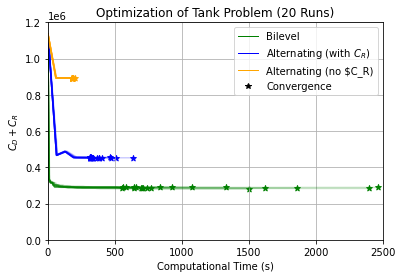

In [14]:
from matplotlib.lines import Line2D
for i, hist in enumerate(fhists_bi):
    plt.plot(thists_bi[i], hist, color='green', label="bilevel", alpha=0.2)
    plt.scatter(thists_bi[i][-1], hist[-1], color='green', marker="*")
for i, hist in enumerate(fhists_alt):
    plt.plot(thists_alt[i], hist, color='blue', label="alt (with $C_R$)", alpha=0.2)
    plt.scatter(thists_alt[i][-1], hist[-1], color='blue', marker="*")
for i,hist in enumerate(fhists_alt_nocr):
    plt.plot(thists_alt_nocr[i], hist, color='orange', label="alt (no $C_R$)", alpha=0.2)
    plt.scatter(thists_alt_nocr[i][-1], hist[-1], color='orange', marker="*")
plt.legend()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
by_label = dict(zip(labels, handles))


legend_elements = [Line2D([0], [0], color='green', lw=1, label='Bilevel'),
                   Line2D([0], [0], color='blue', lw=1, label='Alternating (with $C_R$)'),
                   Line2D([0], [0], color='orange', lw=1, label='Alternating (no $C_R)'),
                   Line2D([0], [0], marker='*', color='black', label='Convergence',
                          markerfacecolor='black',linestyle = 'None')]

ax.legend(handles=legend_elements)
#ax.legend(by_label.values(), by_label.keys(), prop={'size': 8})
ax.set_xlim(0, 2500)
ax.set_ylim(0,1.2e6)
plt.title("Optimization of Tank Problem (20 Runs)")
plt.ylabel("$C_D+C_R$")
#plt.yscale("log")
plt.xlabel("Computational Time (s)")
plt.grid()
fig = plt.gcf()

In [15]:
fig.savefig('tank_optimization.eps', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [265]:
fig.savefig('tank_optimization.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [212]:
conv_time_bi = [thist[-1] for thist in thists_bi]
conv_time_alt = [thist[-1] for thist in thists_alt]
conv_time_alt_nocr = [thist[-1] for thist in  thists_alt_nocr]
conv_time_seq = [thist[1] for thist in thists_alt]
conv_time_seq_nocr = [thist[1] for thist in  thists_alt_nocr]

In [260]:
reconfigs_bi = len([i for i,arg in enumerate(llargs_bi['ll_optx'][1]) if arg!=0 or llargs_bi['ll_optx'][0][i]!=0])
buffers_bi = len([i for i,arg in enumerate(llargs_bi['ll_optx'][0]) if arg>0])

reconfigs_alt = len([i for i,arg in enumerate(llargs_alt['ll_optx'][1]) if arg!=0 or llargs_alt['ll_optx'][0][i]!=0])
buffers_alt = len([i for i,arg in enumerate(llargs_alt['ll_optx'][0]) if arg>0])

reconfigs_alt_nocr= len([i for i,arg in enumerate(llargs_alt_nocr['ll_optx'][1]) if arg!=0 or llargs_alt_nocr['ll_optx'][0][i]!=0])
buffers_alt_nocr = len([i for i,arg in enumerate(llargs_alt_nocr['ll_optx'][0]) if arg>0])

reconfigs_seq = len([i for i,arg in enumerate(llx_seq[1]) if arg!=0 or llx_seq[0][i]!=0])
buffers_seq = len([i for i,arg in enumerate(llx_seq[0]) if arg>0])

reconfigs_seq_nocr = len([i for i,arg in enumerate(llx_seq_nocr[1]) if arg!=0 or llx_seq_nocr[0][i]!=0])
buffers_seq_nocr = len([i for i,arg in enumerate(llx_seq_nocr[0]) if arg>0])

In [261]:
tab = pd.DataFrame(columns = ["$x_t$", "$x_I$", "total LL reconfigs", "total buffer usage", "mean($f^*$)",  "std($f^*$)", "mean time", "std time"])
tab.loc['Bilevel'] = list(result_bi['x']) +[reconfigs_bi, buffers_bi] +  [np.mean(fstars_bi), np.std(fstars_bi), np.mean(conv_time_bi), np.std(conv_time_bi)]
tab.loc['Alt. (with $C_R$)'] = list(result_alt['x']) +[reconfigs_alt,buffers_alt] + [np.mean(fstars_alt), np.std(fstars_alt), np.mean(conv_time_alt), np.std(conv_time_alt)]
tab.loc['Alt. (no $C_R$)'] = list(result_alt_nocr['x']) +[reconfigs_alt_nocr,buffers_alt_nocr] + [np.mean(fstars_alt_nocr), np.std(fstars_alt_nocr), np.mean(conv_time_alt_nocr), np.std(conv_time_alt_nocr)]
tab.loc['Seq. (with $C_R$)'] = list(xdhist_alt[1]) +[reconfigs_seq,buffers_seq ] + [np.mean(fstars_seq), np.std(fstars_seq), np.mean(conv_time_seq), np.std(conv_time_seq)]
tab.loc['Seq. (no $C_R$)'] = list(xdhist_alt_nocr[1]) +[reconfigs_seq_nocr,buffers_seq_nocr] + [np.mean(fstars_seq_nocr), np.std(fstars_seq_nocr[1]), np.mean(conv_time_seq_nocr), np.std(conv_time_seq_nocr)]

In [262]:
tab

,$x_t$,$x_I$,total LL reconfigs,total buffer usage,mean($f^*$),std($f^*$),mean time,std time
Bilevel,18.611203,0.615884,22.0,12.0,287604.141978,2784.633893,1062.487507,586.075880
Alt. (with $C_R$),20.000000,0.000000,21.0,8.0,453566.666823,830.662386,373.035116,83.220694
Alt. (no $C_R$),10.000000,0.000000,23.0,5.0,893333.333333,0.000000,180.879569,6.281634
Seq. (with $C_R$),22.000000,0.000000,20.0,7.0,467133.333389,979.795897,64.729721,2.259097
Seq. (no $C_R$),10.000000,0.000000,24.0,6.0,893333.333333,0.000000,59.891145,1.650289


In [267]:
print(tab.to_latex(float_format="%.2g" ))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  \$x\_t\$ &  \$x\_I\$ &  total LL reconfigs &  total buffer usage &  mean(\$f\textasciicircum *\$) &  std(\$f\textasciicircum *\$) &  mean time &  std time \\
\midrule
Bilevel           &  2e+01 &    0.6 &               2e+01 &               1e+01 &        3e+05 &       3e+03 &      1e+03 &     6e+02 \\
Alt. (with \$C\_R\$) &  2e+01 &      0 &               2e+01 &                   8 &        5e+05 &       8e+02 &      4e+02 &     8e+01 \\
Alt. (no \$C\_R\$)   &  1e+01 &      0 &               2e+01 &                   5 &        9e+05 &           0 &      2e+02 &         6 \\
Seq. (with \$C\_R\$) &  2e+01 &      0 &               2e+01 &                   7 &        5e+05 &       1e+03 &      6e+01 &         2 \\
Seq. (no \$C\_R\$)   &  1e+01 &      0 &               2e+01 &                   6 &        9e+05 &           0 &      6e+01 &         2 \\
\bottomrule
\end{tabular}



In [273]:
print(tab.to_latex(float_format="%.0f"))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  \$x\_t\$ &  \$x\_I\$ &  total LL reconfigs &  total buffer usage &  mean(\$f\textasciicircum *\$) &  std(\$f\textasciicircum *\$) &  mean time &  std time \\
\midrule
Bilevel           &     19 &      1 &                  22 &                  12 &       287604 &        2785 &       1062 &       586 \\
Alt. (with \$C\_R\$) &     20 &      0 &                  21 &                   8 &       453567 &         831 &        373 &        83 \\
Alt. (no \$C\_R\$)   &     10 &      0 &                  23 &                   5 &       893333 &           0 &        181 &         6 \\
Seq. (with \$C\_R\$) &     22 &      0 &                  20 &                   7 &       467133 &         980 &         65 &         2 \\
Seq. (no \$C\_R\$)   &     10 &      0 &                  24 &                   6 &       893333 &           0 &         60 &         2 \\
\bottomrule
\end{tabular}



In [ ]:
print(tab.to_latex(float_format="%.2g" ))

In [152]:
def create_avg_hist(fhists, thists):
    lens = [len(hists) for hists in fhists]
    maxlen=max(lens)
    maxind=np.argmax(lens)
    thist = thists[maxind]
    
    fhist_avg = []; fhist_min =[]; fhist_max = []; fhist_std=[]
    for i in range(maxlen):
        mean_f = np.mean([hist[i] for hist in fhists if i < len(hist)])
        fhist_avg.append(mean_f)
        fhist_min.append(mean_f-np.min([hist[i] for hist in fhists if i < len(hist)]))
        fhist_max.append(np.max([hist[i] for hist in fhists if i < len(hist)])-mean_f)
        fhist_std.append(np.std([hist[i] for hist in fhists if i < len(hist)]))
    return thist, fhist_avg, fhist_min, fhist_max, fhist_std

<ErrorbarContainer object of 3 artists>

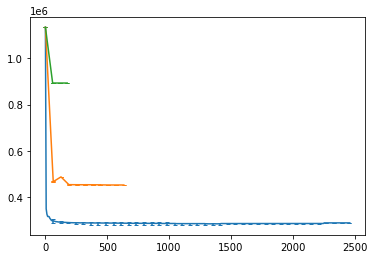

In [159]:
thist, fhist_avg, fhist_min, fhist_max, fhist_std = create_avg_hist(fhists_bi, thists_bi)
plt.errorbar(thist,fhist_avg, yerr =(fhist_min, fhist_max),errorevery=10,capsize=2) #
thist, fhist_avg, fhist_min, fhist_max, fhist_std = create_avg_hist(fhists_alt, thists_alt)
plt.errorbar(thist,fhist_avg, yerr =(fhist_min, fhist_max),capsize=2) #
thist, fhist_avg, fhist_min, fhist_max, fhist_std = create_avg_hist(fhists_alt_nocr, thists_alt_nocr)
plt.errorbar(thist,fhist_avg, yerr =(fhist_min, fhist_max),capsize=2) #